# **Predict Customer Clicked Ads Classification**
---

# Import Library

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import auc, roc_auc_score

# Models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Scikit-learn {sklearn.__version__}')

Scikit-learn 1.2.2


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read Data

In [4]:
# Read data
link = 'https://raw.githubusercontent.com/sabirinID/Predicting-Customer-Clicked-Ads-Classification/main/Dataset/clicked_ads_dataset.csv'
df = pd.read_csv(link, index_col=0)

In [5]:
df.sample(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
346,81.58,25,277893910.0,199.39,Perempuan,5/11/2016 22:02,No,Balikpapan,Kalimantan Timur,Electronic
537,61.72,26,470953420.0,218.49,Perempuan,2/14/2016 7:15,No,Surabaya,Jawa Timur,House
665,58.05,32,111153700.0,195.54,Laki-Laki,2/12/2016 10:39,Yes,Serang,Banten,House
828,66.69,35,341312440.0,108.27,Perempuan,5/11/2016 19:13,Yes,Serang,Banten,Bank
101,63.60,23,363053390.0,235.28,Laki-Laki,6/1/2016 9:27,No,Jakarta Selatan,Daerah Khusus Ibukota Jakarta,House


# Data Understanding

## Features Definition

| Feature Name             | Feature Description                          |
|--------------------------|----------------------------------------------|
| Daily Time Spent on Site | Amount of time spent on the website per day  |
| Age                      | Age of the user                              |
| Area Income              | Income level of the user's area              |
| Daily Internet Usage     | Amount of time spent on the internet per day |
| Male                     | Gender of the user                           |
| Timestamp                | Time and date when the data was recorded     |
| Clicked on Ad            | Whether the user clicked on an ad            |
| city                     | City where the user is located               |
| province                 | Province where the user is located           |
| category                 | Category of the ad                           |


## Dimensions of the DataFrame

In [6]:
df.shape

(1000, 10)

In [7]:
print('Dataset ini memiliki dimensi data, yaitu')
print('Jumlah baris: {}'.format(df.shape[0]))
print('Jumlah kolom: {}'.format(df.shape[1]))

Dataset ini memiliki dimensi data, yaitu
Jumlah baris: 1000
Jumlah kolom: 10


## Data Types of the Features

In [8]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


🔎 Observasi
- Tipe data: float64, int64, dan object.
- Fitur `Daily Time Spent on Site`, `Area Income`, `Daily Internet Usage`, dan `Male` memiliki kurang dari 2.240 _non-null values_.
- Fitur `Timestamp` seharusnya memiliki tipe data datetime bukan object, sehingga harus diubah.
- Beberapa fitur perlu diubah penamaannya agar tidak menimbulkan ketidakjelasan atau ambiguitas. Penamaan fitur akan menggunakan kaidah penamaan `PascalCase` atau `UpperCamelCase`.

In [9]:
# Fix data type: object to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Rename features
features = {
    'Daily Time Spent on Site': 'DailyTimeSpent',
    'Area Income'             : 'Income',
    'Daily Internet Usage'    : 'DailyInternetUsage',
    'Male'                    : 'Gender',
    'Clicked on Ad'           : 'ClickedAd',
    'city'                    : 'City',
    'province'                : 'Province',
    'category'                : 'AdCategory'
}
df = df.rename(columns=features)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DailyTimeSpent      987 non-null    float64       
 1   Age                 1000 non-null   int64         
 2   Income              987 non-null    float64       
 3   DailyInternetUsage  989 non-null    float64       
 4   Gender              997 non-null    object        
 5   Timestamp           1000 non-null   datetime64[ns]
 6   ClickedAd           1000 non-null   object        
 7   City                1000 non-null   object        
 8   Province            1000 non-null   object        
 9   AdCategory          1000 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 85.9+ KB


✅ Tipe data untuk setiap fitur dalam dataset sudah sesuai.

# Data Exploration

## Exploratory Data Analysis

### Statistical Analysis

In [11]:
# Statistics for the columns (features)
df.describe(include='all')

,DailyTimeSpent,Age,Income,DailyInternetUsage,Gender,Timestamp,ClickedAd,City,Province,AdCategory
count,987.000000,1000.000000,9.870000e+02,989.000000,997,1000,1000,1000,1000,1000
unique,NaN,NaN,NaN,NaN,2,NaN,2,30,16,10
top,NaN,NaN,NaN,NaN,Perempuan,NaN,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif
freq,NaN,NaN,NaN,NaN,518,NaN,500,64,253,112
mean,64.929524,36.009000,3.848647e+08,179.863620,NaN,2016-04-10 10:33:36.840000,NaN,NaN,NaN,NaN
min,32.600000,19.000000,9.797550e+07,104.780000,NaN,2016-01-01 02:52:00,NaN,NaN,NaN,NaN
25%,51.270000,29.000000,3.286330e+08,138.710000,NaN,2016-02-18 02:55:15,NaN,NaN,NaN,NaN
50%,68.110000,35.000000,3.990683e+08,182.650000,NaN,2016-04-07 17:27:00,NaN,NaN,NaN,NaN
75%,78.460000,42.000000,4.583554e+08,218.790000,NaN,2016-05-31 03:18:00,NaN,NaN,NaN,NaN
max,91.430000,61.000000,5.563936e+08,267.010000,NaN,2016-07-24 00:22:00,NaN,NaN,NaN,NaN


In [12]:
# Define features
num = df.select_dtypes(include=['float64', 'int64'])
cat = df.select_dtypes(include=['object'])

num_cols = num.columns
cat_cols = cat.columns

In [13]:
print(f'Jumlah fitur numerikal  : {num.shape[1]}')
print(f'Jumlah fitur kategorikal: {cat.shape[1]}')

Jumlah fitur numerikal  : 4
Jumlah fitur kategorikal: 5


### Univariate Analysis

#### Numerical Features

In [14]:
num.describe()

,DailyTimeSpent,Age,Income,DailyInternetUsage
count,987.000000,1000.000000,9.870000e+02,989.000000
mean,64.929524,36.009000,3.848647e+08,179.863620
std,15.844699,8.785562,9.407999e+07,43.870142
min,32.600000,19.000000,9.797550e+07,104.780000
25%,51.270000,29.000000,3.286330e+08,138.710000
50%,68.110000,35.000000,3.990683e+08,182.650000
75%,78.460000,42.000000,4.583554e+08,218.790000
max,91.430000,61.000000,5.563936e+08,267.010000


🔎 Observasi
- Sebagian besar pengguna berusia 35 tahun.
- Mayoritas pengguna memiliki `DailyTimeSpent` selama 68 menit/hari atau sekitar 1 jam/hari.
- Mayoritas pengguna memiliki `Income` sebesar Rp399.068.320/tahun.
- Mayoritas pengguna memiliki `DailyInternetUsage` sebanyak 183 menit/hari atau sekitar 3 jam/hari.

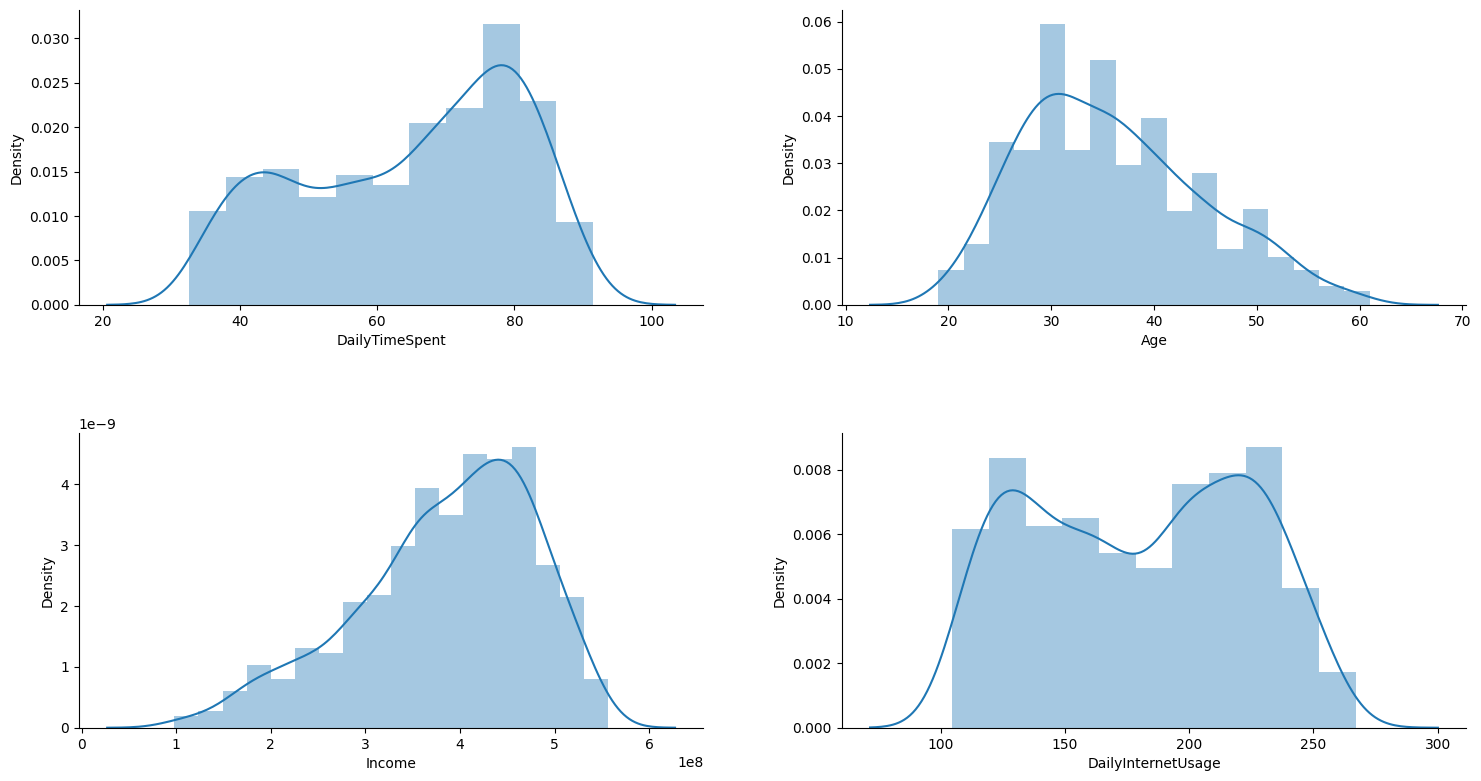

In [15]:
plt.figure(figsize=(16, 9))
for i in range(0, len(num_cols)):
    plt.subplot(2, 2, i+1)
    sns.distplot(df[num_cols[i]])
    sns.despine()
    plt.tight_layout(pad=5)

plt.show()

🔎 Insights
- Fitur `Age` memiliki distribusi yang cenderung _positively skewed_ atau menceng kanan, sedangkan `Income` memiliki distribusi yang cenderung _negatively skewed_ atau menceng kiri.
- Fitur `DailyTimeSpent` dan `DailyInternetUsage` memiliki distribusi yang cenderung normal.

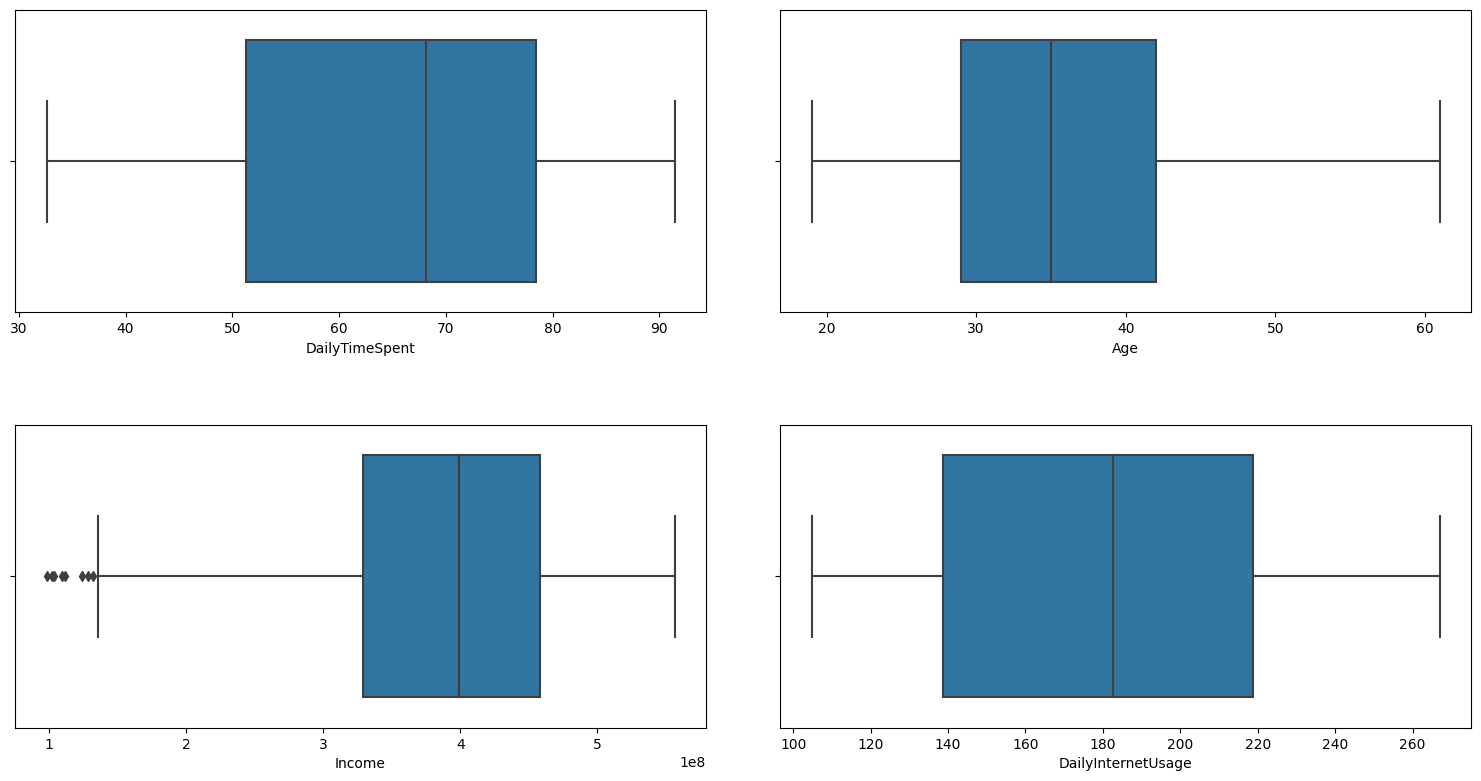

In [16]:
plt.figure(figsize=(16, 9))

for i in range(0, len(num_cols)):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[num_cols[i]])
    plt.tight_layout(pad=5)

🔎 Insights
- Terdapat _outlier_ pada fitur `Income`, sehingga kita akan menghapus poin data tersebut agar tidak mengurangi _insight_ yang diperoleh dari analisis data.

#### Categorical Features

In [17]:
cat.describe()

,Gender,ClickedAd,City,Province,AdCategory
count,997,1000,1000,1000,1000
unique,2,2,30,16,10
top,Perempuan,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif
freq,518,500,64,253,112


🔽 `Gender`

In [18]:
df['Gender'].value_counts(normalize=True)

Gender
Perempuan    0.519559
Laki-Laki    0.480441
Name: proportion, dtype: float64

🔽 `ClickedAd`

In [19]:
df['ClickedAd'].value_counts(normalize=True)

ClickedAd
No     0.5
Yes    0.5
Name: proportion, dtype: float64

🔽 `City`

In [20]:
df['City'].value_counts(normalize=True).head()

City
Surabaya           0.064
Bandung            0.064
Jakarta Timur      0.063
Jakarta Selatan    0.061
Jakarta Barat      0.057
Name: proportion, dtype: float64

🔽 `Province`

In [21]:
df['Province'].value_counts(normalize=True).head()

Province
Daerah Khusus Ibukota Jakarta    0.253
Jawa Barat                       0.210
Jawa Timur                       0.090
Banten                           0.076
Jawa Tengah                      0.053
Name: proportion, dtype: float64

🔽 `AdCategory`

In [22]:
df['AdCategory'].value_counts(normalize=True).head()

AdCategory
Otomotif    0.112
House       0.109
Health      0.104
Fashion     0.102
Food        0.099
Name: proportion, dtype: float64

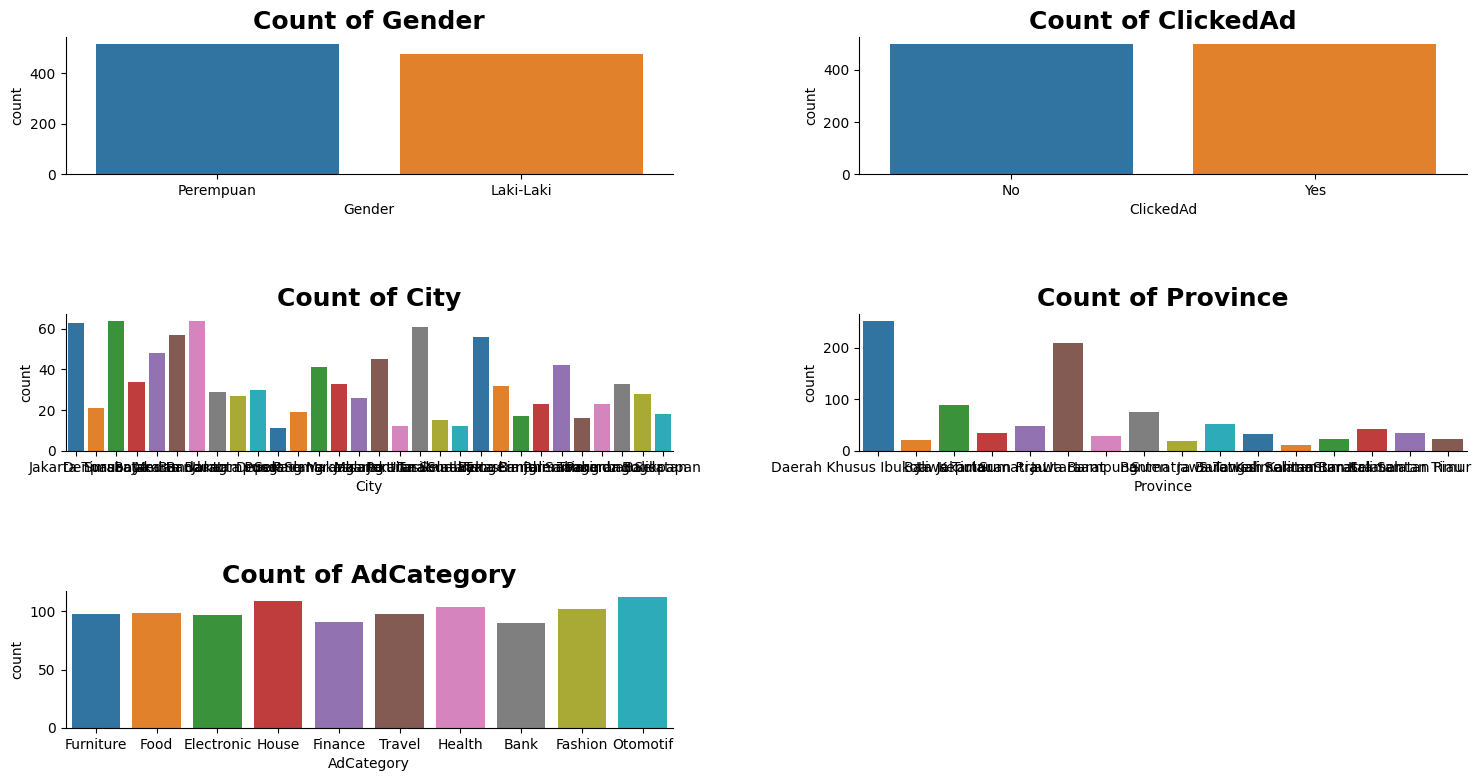

In [23]:
plt.figure(figsize=(16, 9))
for i in range(0, len(cat_cols)):
    plt.subplot(3, 2, i+1)
    ax = sns.countplot(x=df[cat_cols[i]], palette='tab10')
    plt.title(f'Count of {cat_cols[i]}', fontsize=18, weight='bold')
    sns.despine()
    plt.tight_layout(pad=5)

plt.show()

🔎 Insights
- Sebanyak 52% pengguna adalah perempuan.
- Pada fitur target atau `ClickedAd`, sebanyak 50% pengguna mengeklik iklan di website, sehingga kita akan menggunakan metrik akurasi, karena lebih cocok untuk data yang seimbang.
- Mayoritas pengguna berasal dari kota Surabaya.
- Mayoritas pengguna berasal dari provinsi DKI Jakarta (25,3%) dan Jawa Barat (21%).
- Mayoritas pengguna mengeklik pada kategori "Otomotif".

### Bivariate Analysis

#### `DailyTimeSpent` and `DailyInternetUsage` vs. `AgeGroup`

In [24]:
df['Age'].unique()

array([35, 31, 26, 29, 23, 33, 48, 30, 20, 49, 37, 24, 41, 36, 40, 52, 28,
       34, 22, 57, 53, 39, 46, 32, 25, 43, 45, 50, 47, 27, 42, 38, 54, 21,
       60, 55, 44, 58, 56, 51, 19, 59, 61], dtype=int64)

🔎 Observasi
- Dari fitur `Age` akan ekstrak menjadi fitur baru, yaitu `AgeGroup` (kelompok usia).
    - <21 tahun,
    - 21-30 tahun,
    - 31-40 tahun,
    - 41-50 tahun, dan
    - \>50 tahun.

In [25]:
# Age group
df['AgeGroup'] = df['Age'].apply(lambda x: '< 21' if x < 21 else (
                                           '21-30' if x < 31 else (
                                           '31-40' if x < 41 else (
                                           '41-50' if x < 51 else (
                                           '> 50')))))

labels = ['< 21', '21-30', '31-40', '41-50', '> 50']
df['AgeGroup'] = pd.Categorical(df['AgeGroup'], categories=labels)
df['AgeGroup'].value_counts()

AgeGroup
31-40    408
21-30    291
41-50    217
> 50      72
< 21      12
Name: count, dtype: int64

In [26]:
# Daily Time Spent
dts = df.groupby('AgeGroup')['DailyTimeSpent'].mean().round(2).reset_index()

# Daily Internet Usage
diu = df.groupby('AgeGroup')['DailyInternetUsage'].mean().round(2).reset_index()

In [27]:
dts

,AgeGroup,DailyTimeSpent
0,< 21,63.84
1,21-30,69.97
2,31-40,67.23
3,41-50,56.92
4,> 50,55.89


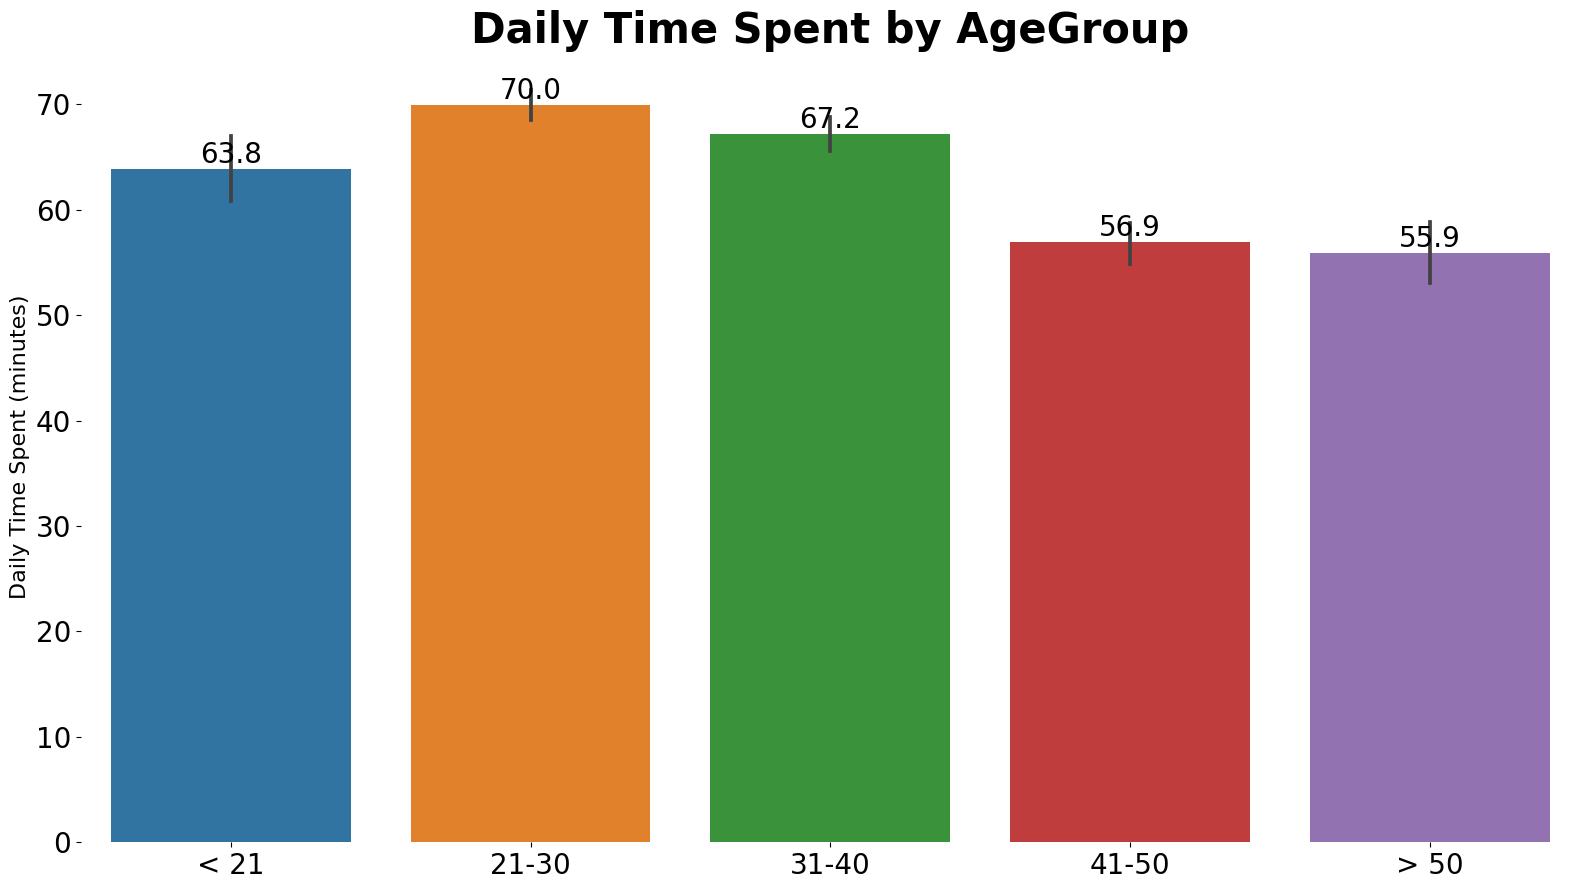

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

ax = sns.barplot(x='AgeGroup',
                 y='DailyTimeSpent',
                 data=df, palette='tab10')

plt.title('Daily Time Spent by AgeGroup', weight='bold', fontsize=30)
plt.bar_label(ax.containers[0], fmt='%.1f', fontsize=20)
plt.xlabel('')
plt.ylabel('Daily Time Spent (minutes)', fontsize=16)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.show()

In [29]:
diu

,AgeGroup,DailyInternetUsage
0,< 21,191.41
1,21-30,195.72
2,31-40,186.25
3,41-50,153.75
4,> 50,156.98


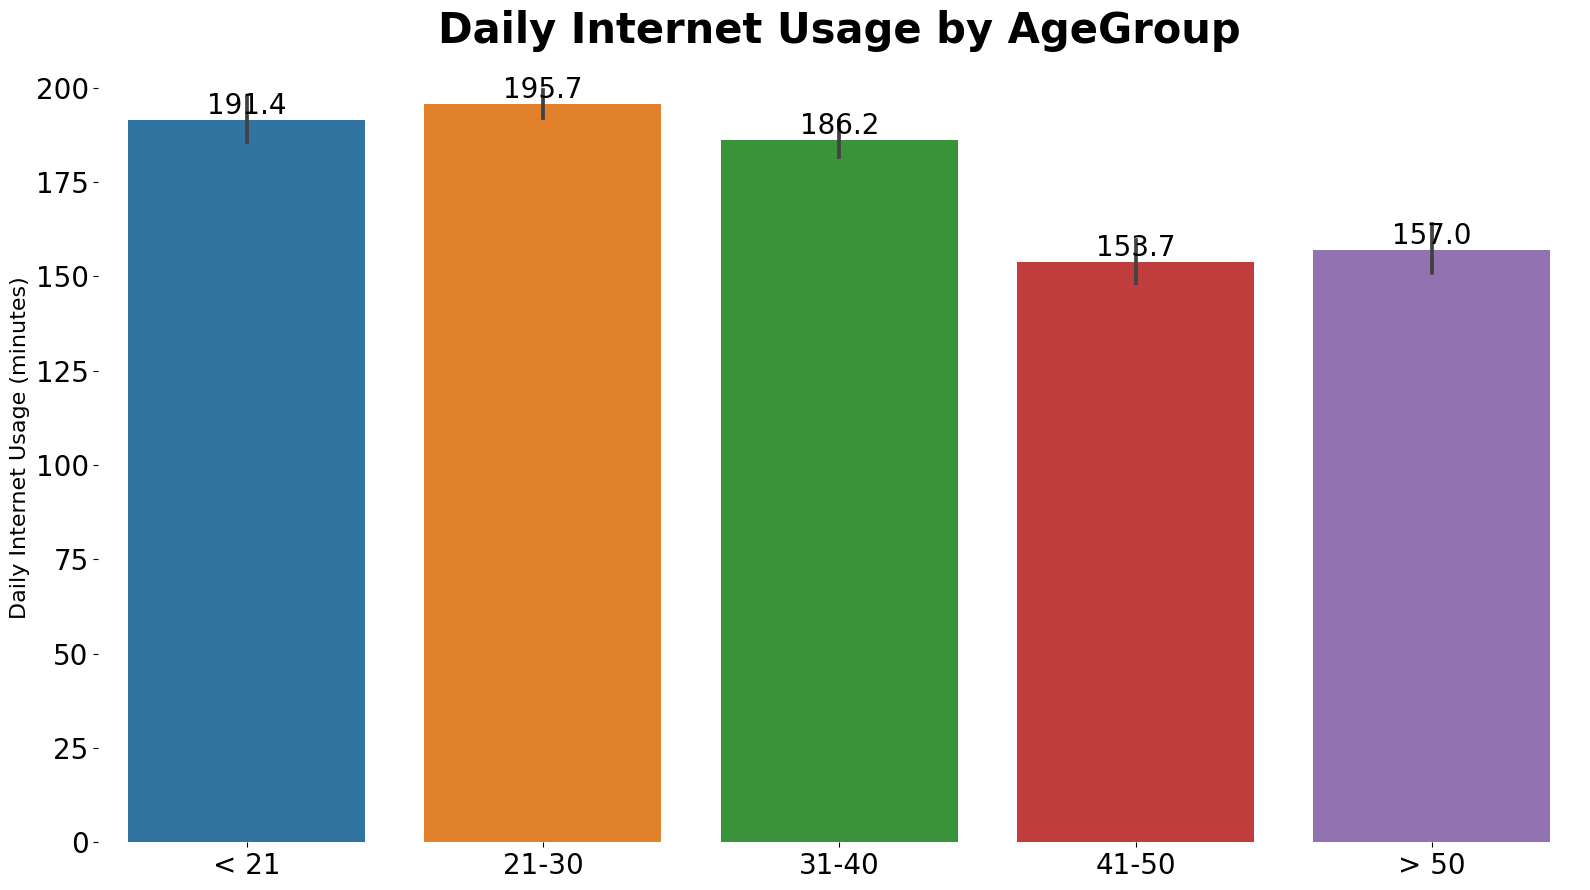

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

ax = sns.barplot(x='AgeGroup',
                 y='DailyInternetUsage',
                 data=df, palette='tab10')

plt.title('Daily Internet Usage by AgeGroup', weight='bold', fontsize=30)
plt.bar_label(ax.containers[0], fmt='%.1f', fontsize=20)
plt.xlabel('')
plt.ylabel('Daily Internet Usage (minutes)', fontsize=16)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.show()

#### `ClickedAd` vs. `DailyTimeSpent`, `DailyInternetUsage`, and `Age`

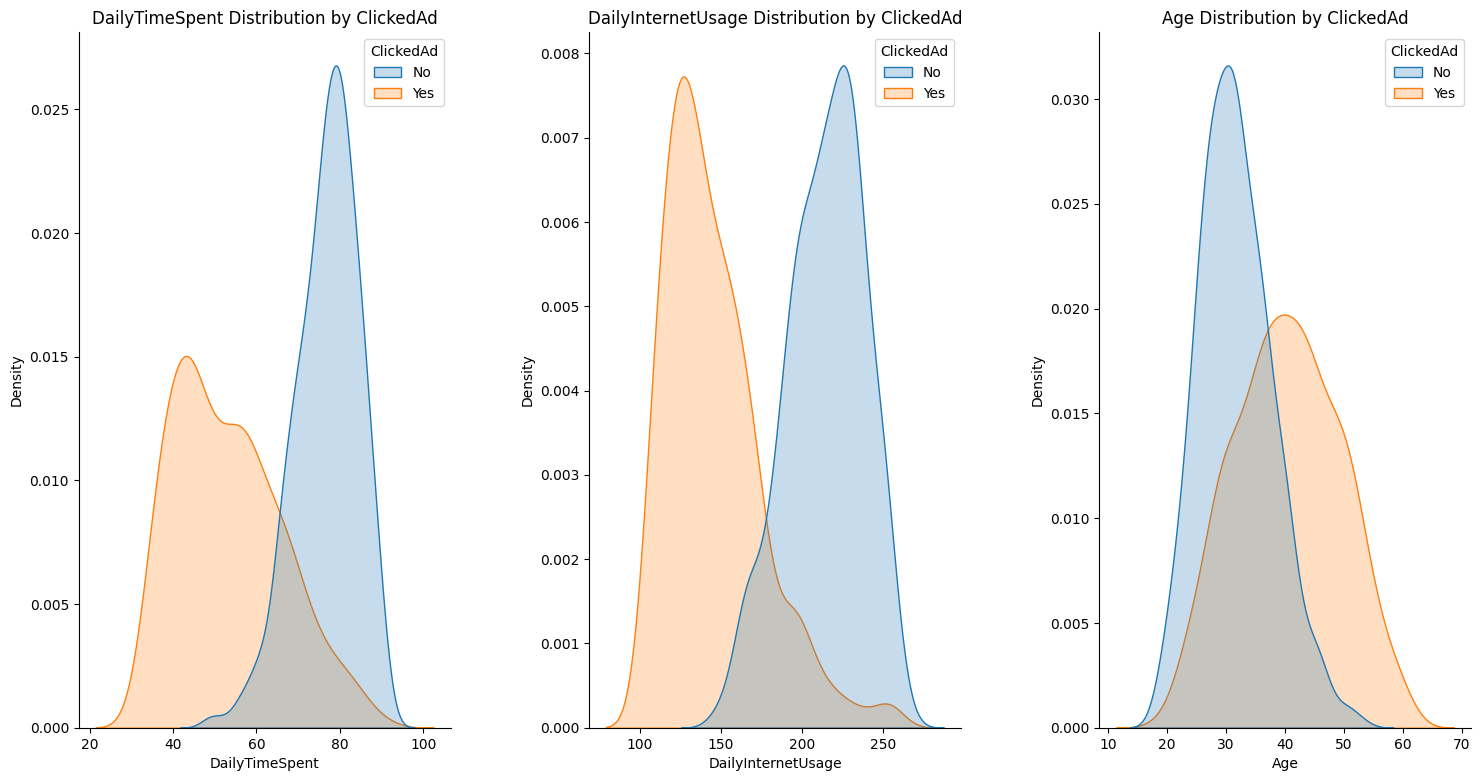

In [31]:
variable = ['DailyTimeSpent', 'DailyInternetUsage', 'Age']

plt.figure(figsize=(16, 9))
for var in range(0, len(variable)):
    plt.subplot(1, 3, var+1)
    sns.kdeplot(x=df[variable[var]], hue=df['ClickedAd'], data=df, fill=True).set(title=f'{variable[var]} Distribution by ClickedAd')
    sns.despine()
    plt.tight_layout(pad=5)

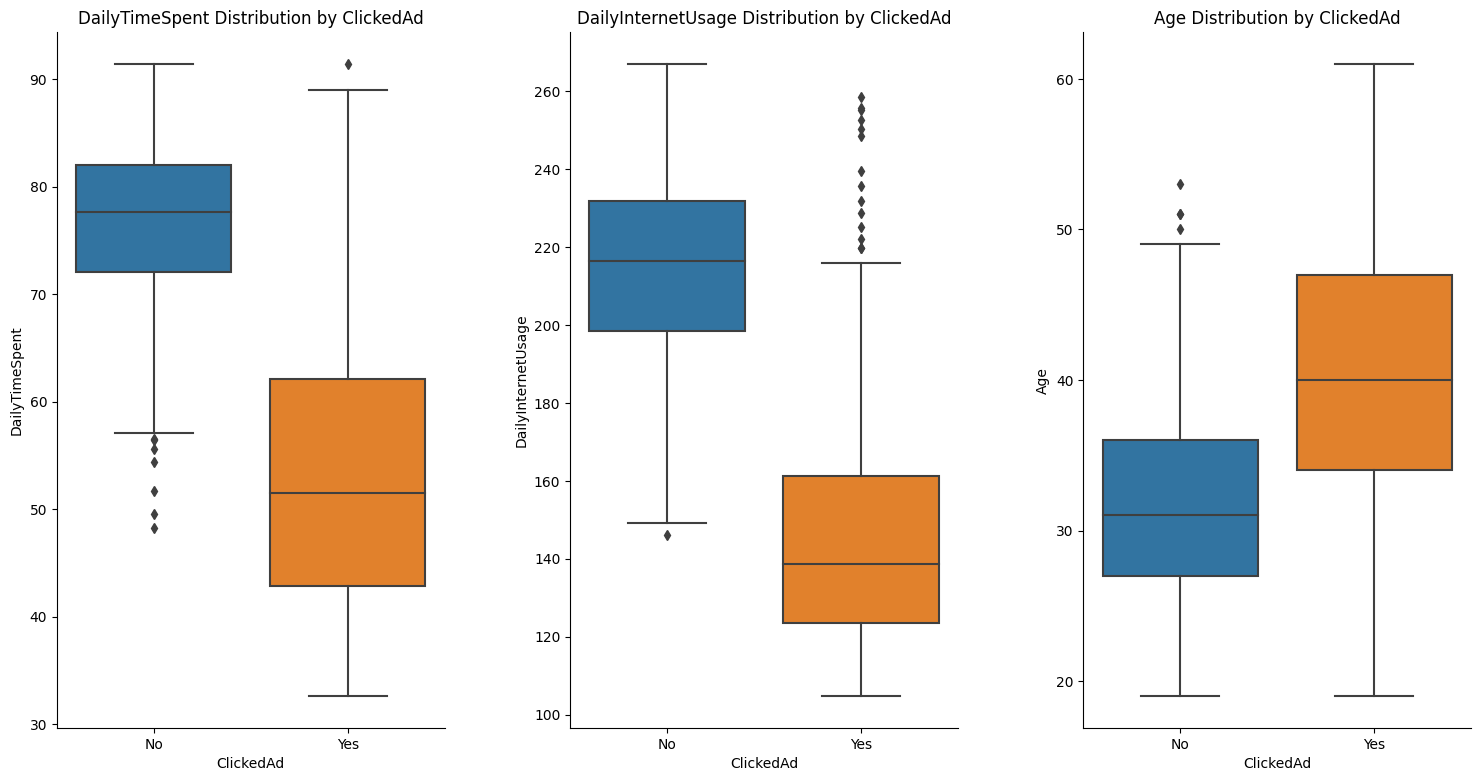

In [32]:
plt.figure(figsize=(16, 9))
for var in range(0, len(variable)):
    plt.subplot(1, 3, var+1)
    sns.boxplot(x=df['ClickedAd'], y=df[variable[var]]).set(title=f'{variable[var]} Distribution by ClickedAd')
    sns.despine()
    plt.tight_layout(pad=5)

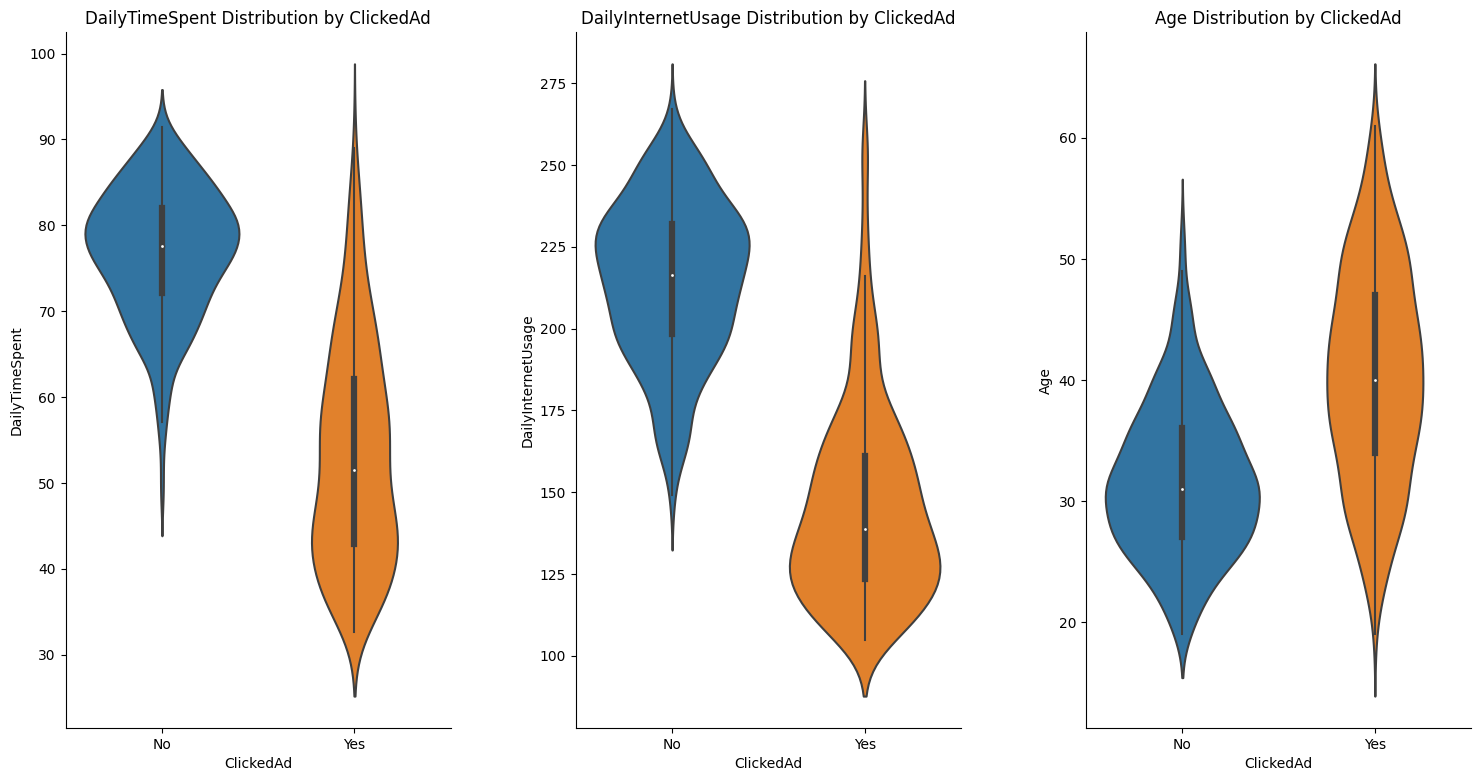

In [33]:
plt.figure(figsize=(16, 9))
for var in range(0, len(variable)):
    plt.subplot(1, 3, var+1)
    sns.violinplot(x=df['ClickedAd'], y=df[variable[var]]).set(title=f'{variable[var]} Distribution by ClickedAd')
    sns.despine()
    plt.tight_layout(pad=5)

🔎 Insights
- Pengguna dengan `DailyTimeSpent` kurang dari 60 menit memiliki kecenderungan untuk mengeklik iklan yang lebih besar.
- Pengguna yang jarang menggunakan internet (`DailyInternetUsage` kurang dari 180 menit) memiliki kecenderungan untuk mengeklik iklan yang lebih besar dibandingkan pengguna yang sering menggunakan internet.
- Pengguna dengan usia 40 tahun ke atas memiliki kecenderungan untuk mengeklik iklan yang lebih besar.

#### `DailyTimeSpent` and `DailyInternetUsage` vs. `Age`

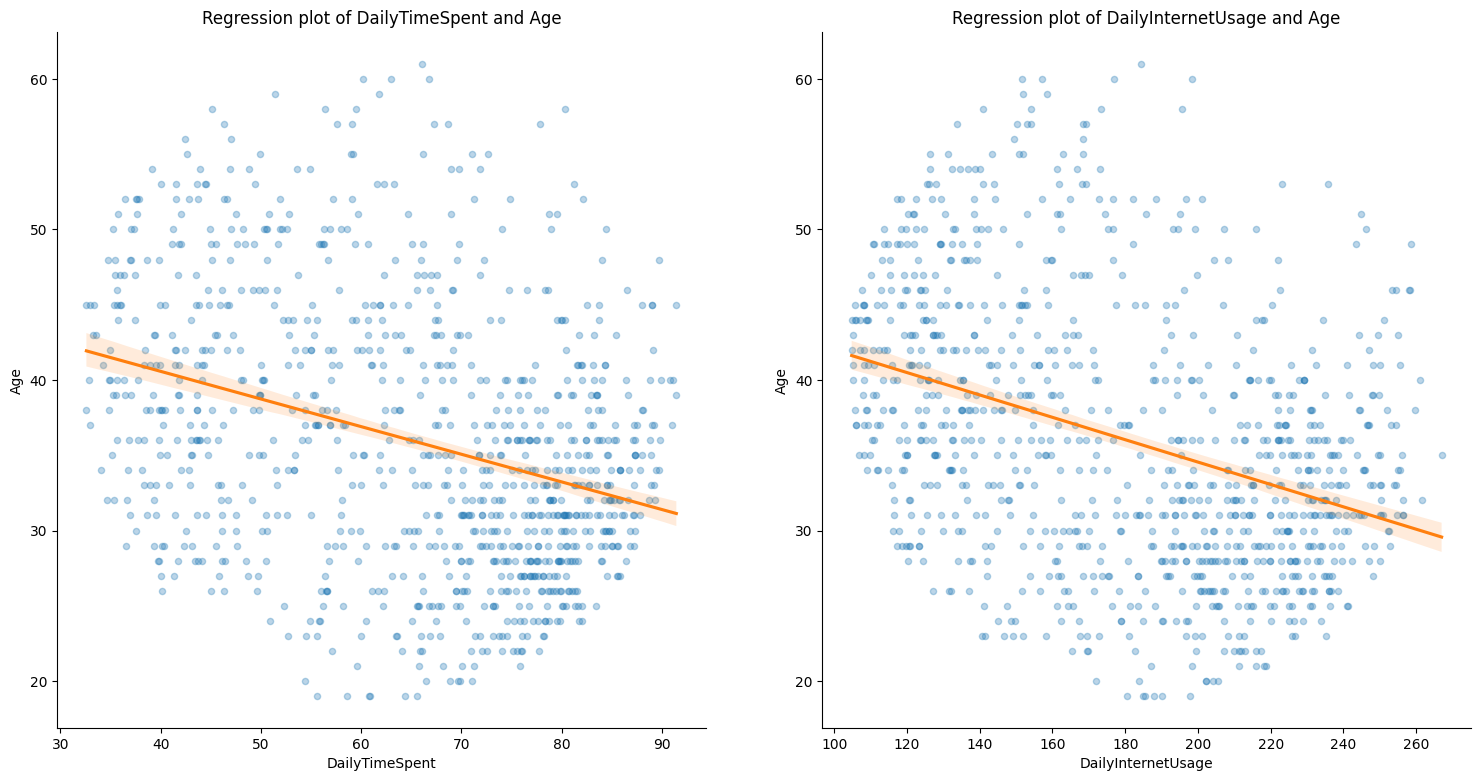

In [34]:
variable = ['DailyTimeSpent', 'DailyInternetUsage']

plt.figure(figsize=(16, 9))
for var in range(0, len(variable)):
    plt.subplot(1, 2, var+1)
    sns.regplot(x=df[variable[var]], y='Age', data=df, scatter_kws={'s':20, 'alpha':0.3}, 
                line_kws={'color':'tab:orange'}).set(title=f'Regression plot of {variable[var]} and Age')
    sns.despine()
    plt.tight_layout(pad=5)

🔎 Insights
- Terdapat korelasi negatif yang kuat antara `Age` dan `DailyTimeSpent` ataupun `DailyInternetUsage`.

#### `DailyTimeSpent` vs. `DailyInternetUsage`

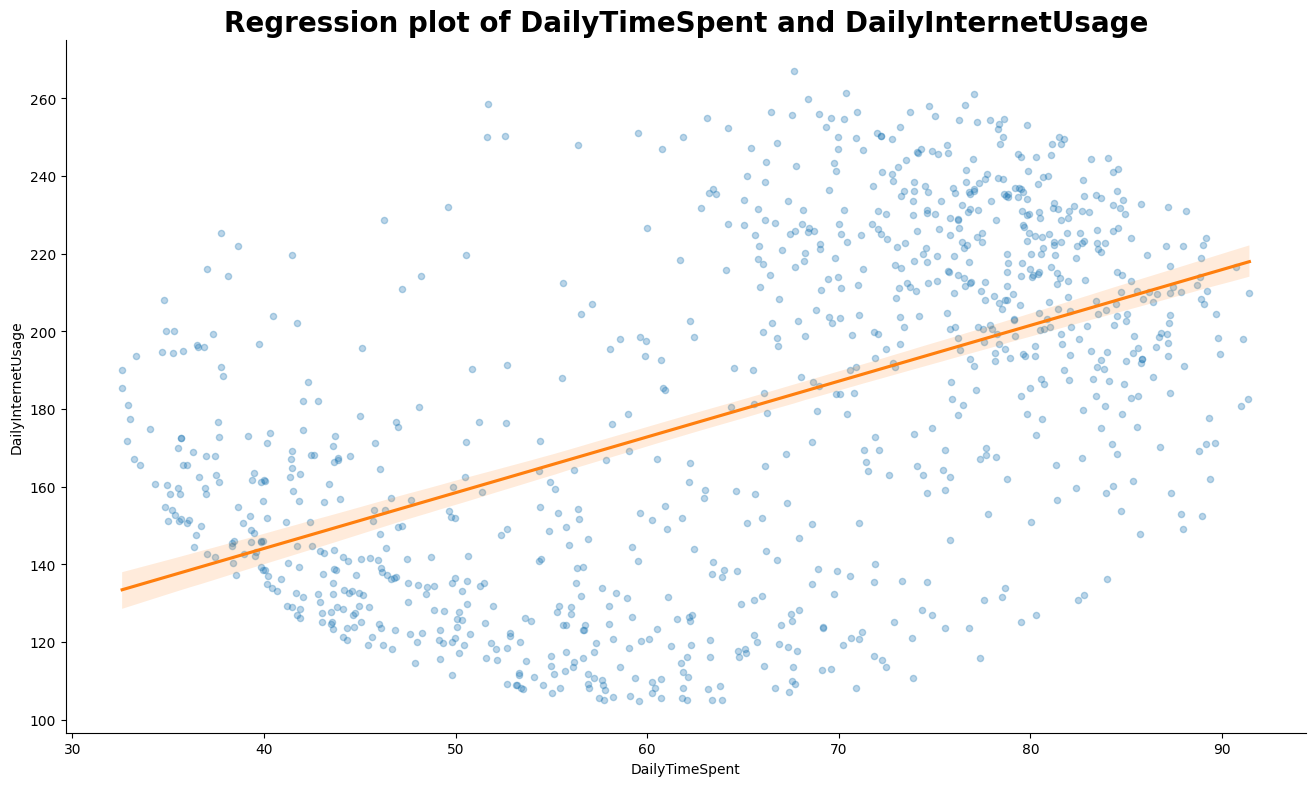

In [35]:
plt.figure(figsize=(16, 9))
sns.regplot(x='DailyTimeSpent', y='DailyInternetUsage', data=df, scatter_kws={'s':20, 'alpha':0.3},
            line_kws={'color':'tab:orange'})
sns.despine()

plt.title('Regression plot of DailyTimeSpent and DailyInternetUsage', weight='bold', fontsize=20)
plt.show()

🔎 Insights
- Terdapat korelasi positif yang kuat antara `DailyTimeSpent` dan `DailyInternetUsage`.
- Makin lama waktu yang dihabiskan di website, makin sering pengguna menggunakan internet.

#### `ClickedAd` and Sessions

In [36]:
# Define features
df['Month'] = df['Timestamp'].dt.month
df['Week'] = df['Timestamp'].dt.dayofweek
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df = df.drop(['Timestamp'], axis=1)

##### `Monthly` Sessions

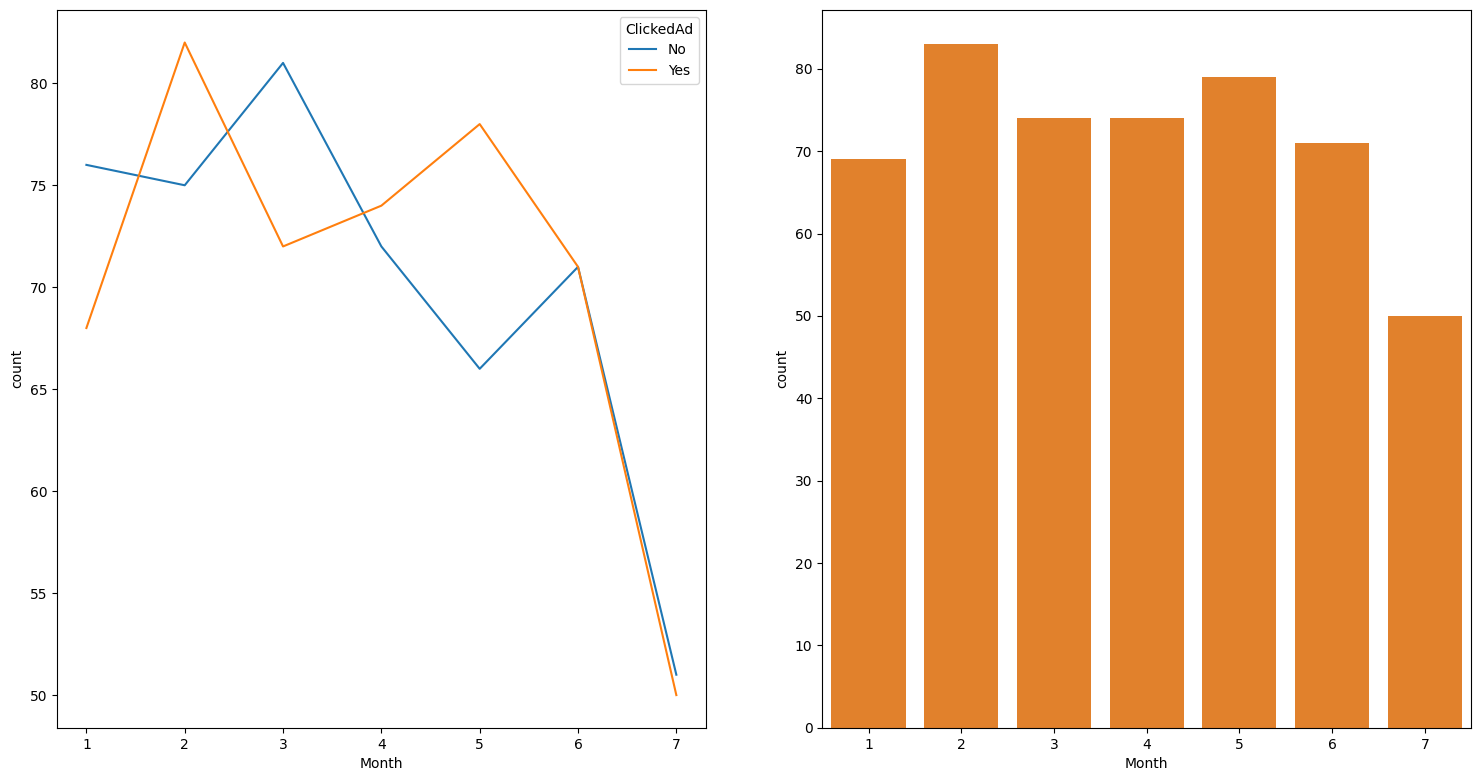

In [37]:
monthly_sessions = df.groupby(['Month', 'ClickedAd'])[['DailyTimeSpent']].count()
monthly_sessions.rename(columns={'DailyTimeSpent': 'count'}, inplace=True)
monthly_sessions.reset_index()

f, ax=plt.subplots(1, 2, figsize=(16, 9))
sns.lineplot(x='Month', y='count', hue='ClickedAd', data=monthly_sessions, ax=ax[0])
sns.countplot(data=df[df['ClickedAd'] == 'Yes'], x='Month', color='tab:orange', ax=ax[1])
plt.tight_layout(pad=5)
plt.show()

##### `Weekly` Sessions

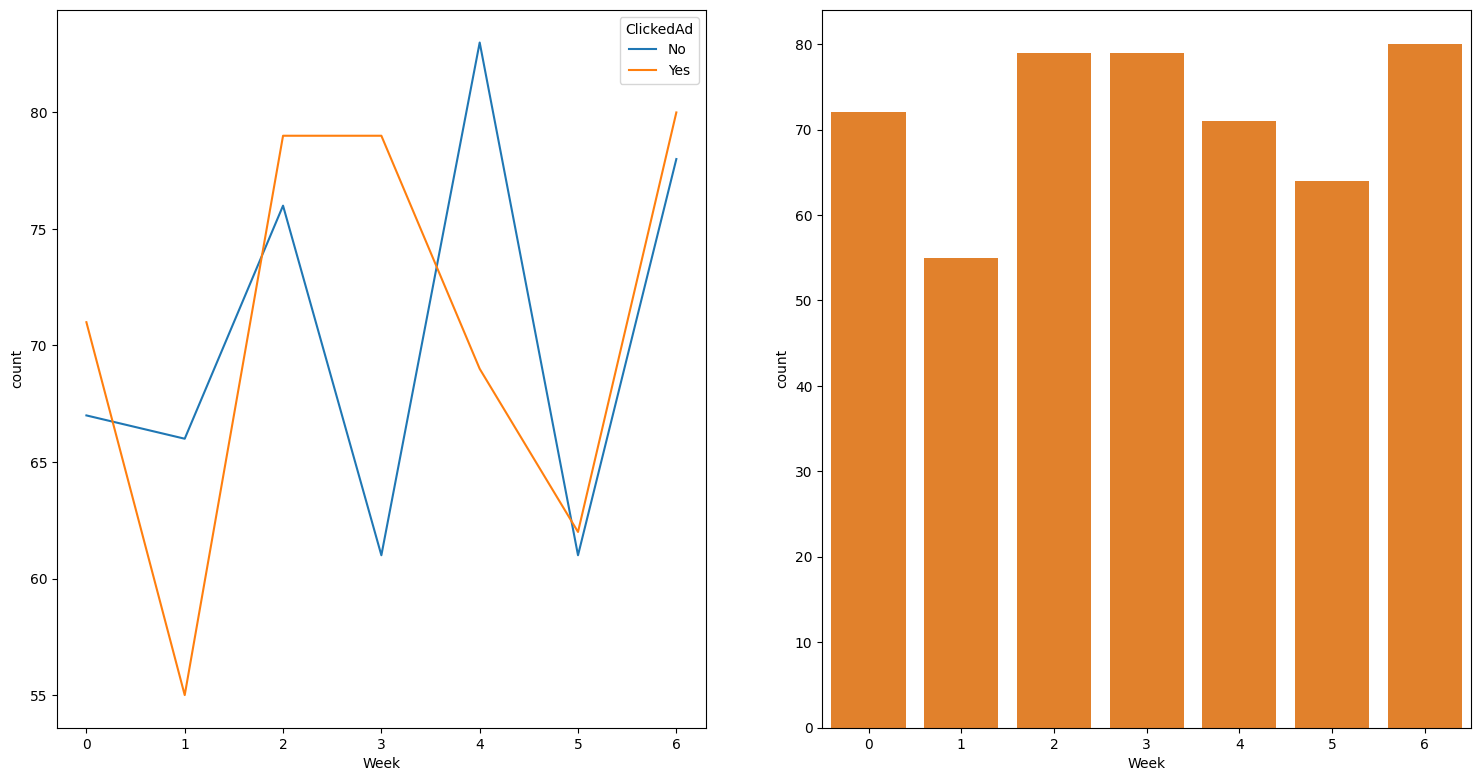

In [38]:
weekly_sessions = df.groupby(['Week', 'ClickedAd'])[['DailyTimeSpent']].count()
weekly_sessions.rename(columns={'DailyTimeSpent': 'count'}, inplace=True)
weekly_sessions.reset_index()

f, ax=plt.subplots(1, 2, figsize=(16, 9))
sns.lineplot(x='Week', y='count', hue='ClickedAd', data=weekly_sessions, ax=ax[0])
sns.countplot(data=df[df['ClickedAd'] == 'Yes'], x='Week', color='tab:orange', ax=ax[1])
plt.tight_layout(pad=5)
plt.show()

##### `Daily` Sessions

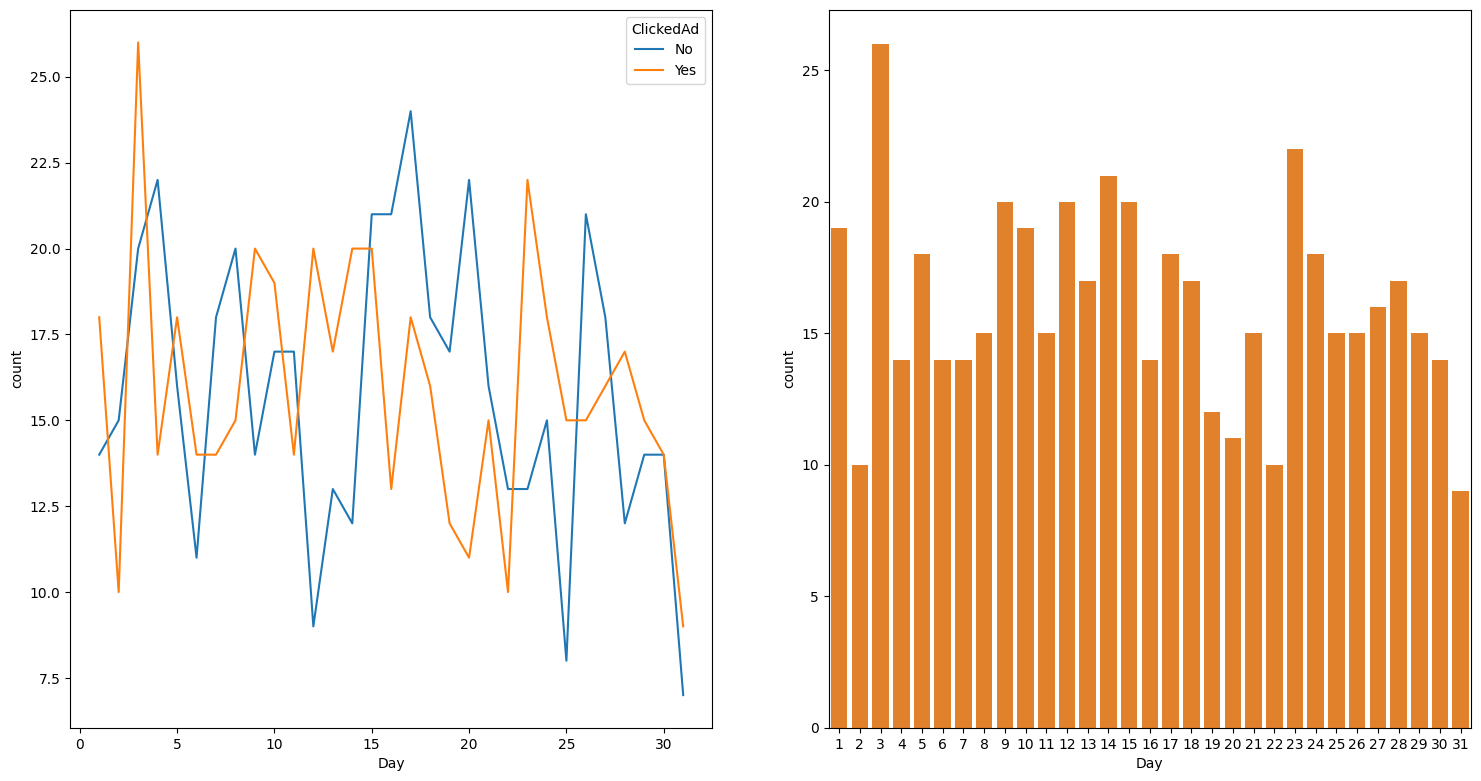

In [39]:
daily_sessions = df.groupby(['Day', 'ClickedAd'])[['DailyTimeSpent']].count()
daily_sessions.rename(columns={'DailyTimeSpent': 'count'}, inplace=True)
daily_sessions.reset_index()

f, ax=plt.subplots(1, 2, figsize=(16, 9))
sns.lineplot(x='Day', y='count', hue='ClickedAd', data=daily_sessions, ax=ax[0])
sns.countplot(data=df[df['ClickedAd'] == 'Yes'], x='Day', color='tab:orange', ax=ax[1])
plt.tight_layout(pad=5)
plt.show()

##### `Hourly` Sessions

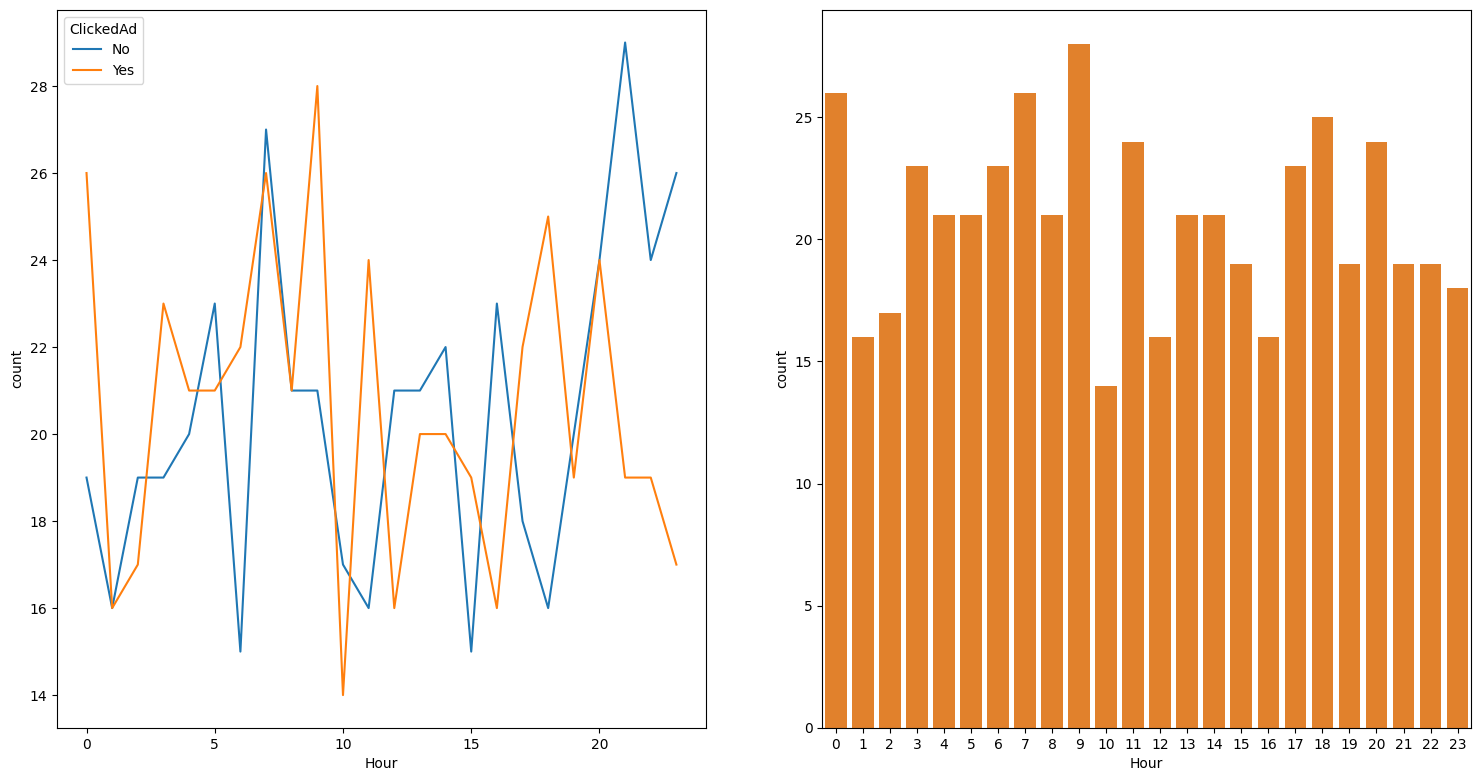

In [40]:
hourly_sessions = df.groupby(['Hour', 'ClickedAd'])[['DailyTimeSpent']].count()
hourly_sessions.rename(columns={'DailyTimeSpent': 'count'}, inplace=True)
hourly_sessions.reset_index()

f, ax=plt.subplots(1, 2, figsize=(16, 9))
sns.lineplot(x='Hour', y='count', hue='ClickedAd', data=hourly_sessions, ax=ax[0])
sns.countplot(data=df[df['ClickedAd'] == 'Yes'], x='Hour', color='tab:orange', ax=ax[1])
plt.tight_layout(pad=5)
plt.show()

🔎 Insights
- Terdapat banyak jumlah pengguna yang mengeklik iklan pada bulan Februari dan Mei.
- Terdapat sedikit jumlah pengguna yang mengeklik iklan pada hari Senin dan Jumat.
- Hari Rabu memiliki tingkat konversi yang tertinggi dalam mengeklik iklan.
- Hari Senin dan Jumat masing-masing merupakan awal dan akhir hari-hari kerja, sehingga pada hari tersebut cenderung memiliki tingkat konversi yang rendah.
- Pada tanggal 3 dan 23 memiliki tingkat konversi yang tinggi dalam mengeklik iklan.
- Terdapat kecenderungan pengguna untuk mengeklik iklan pada jam 00:00, 09:00, 11:00, dan 18:00. Hal ini mungkin terkait dengan kebiasaan pengguna dalam menggunakan _gadget_.

### Multivariate Analysis

In [41]:
features = ['Age', 'Income', 'DailyTimeSpent', 'DailyInternetUsage']

<Figure size 1600x900 with 0 Axes>

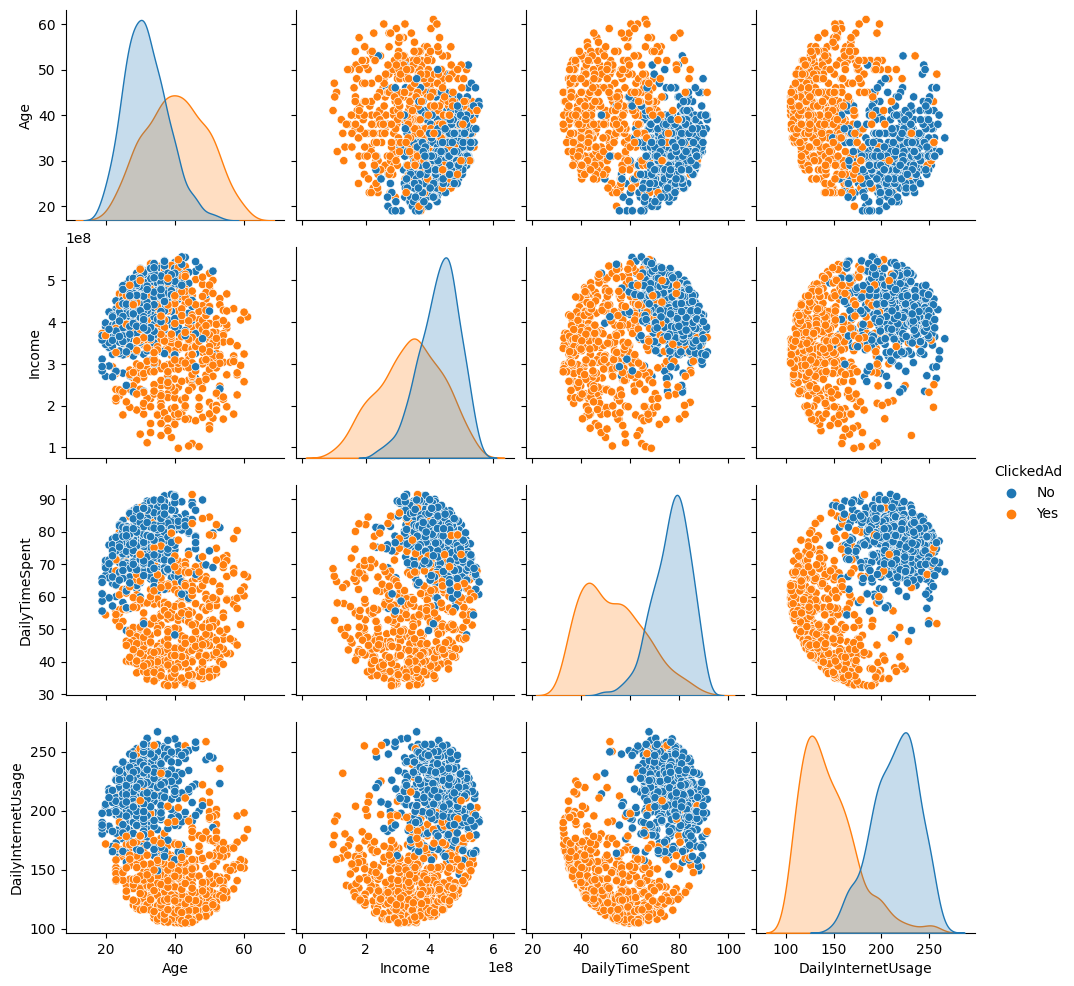

In [42]:
plt.figure(figsize=(16, 9))
sns.pairplot(data=df, vars=features, hue='ClickedAd', palette='tab10')
plt.show()

🔎 Insights
- Berdasarkan pola antara `DailyTimeSpent` dan `DailyInternetUsage`, pengguna dapat dikategorikan menjadi aktif atau nonaktif.
- Pengguna yang termasuk dalam kategori aktif cenderung tidak terlalu tertarik untuk mengeklik iklan. Oleh karena itu, perusahaan dapat mengarahkan target iklannya kepada pengguna yang termasuk dalam kategori nonaktif.

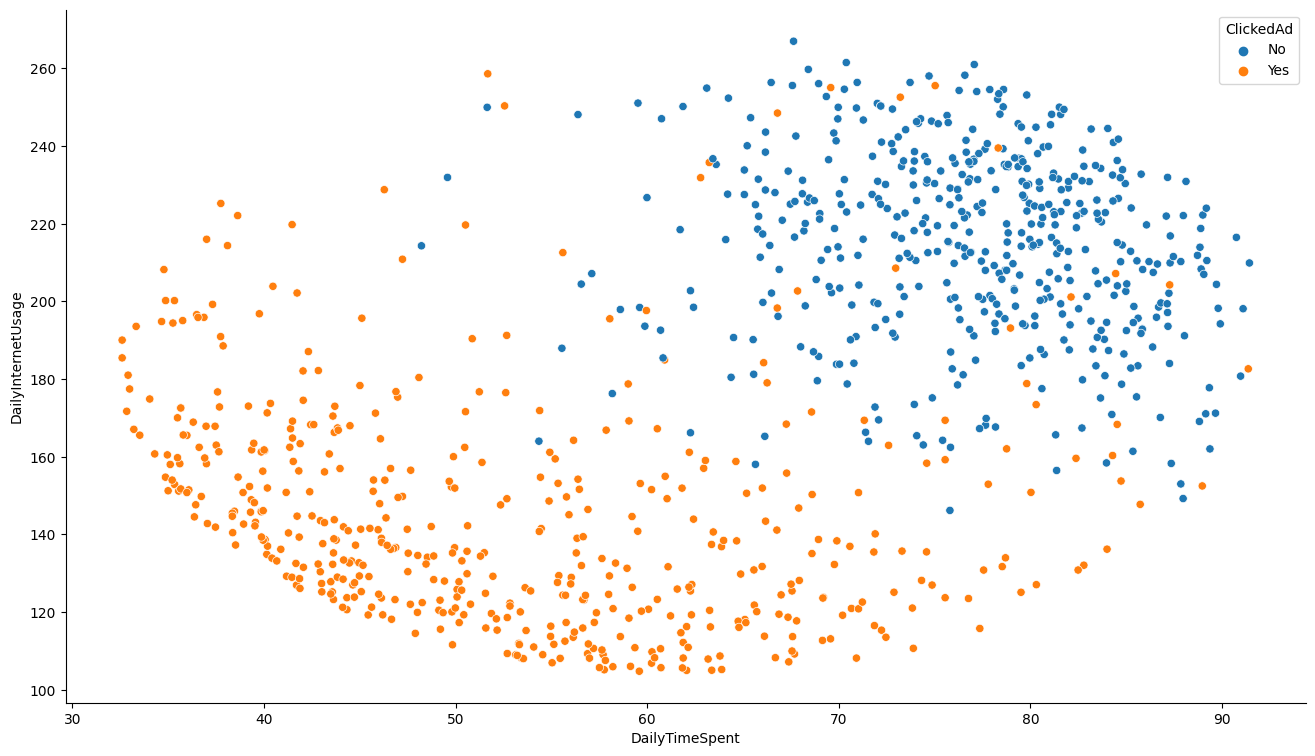

In [43]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x=df['DailyTimeSpent'], y=df['DailyInternetUsage'], hue=df['ClickedAd'])
sns.despine()
plt.show()

### Correlation Matrix

In [44]:
df['Gender'] = df['Gender'].replace({'Perempuan': 0, 'Laki-Laki': 1})
df['ClickedAd'] = df['ClickedAd'].replace({'No': 0, 'Yes': 1})

In [45]:
features = ['Age', 'Income', 'DailyTimeSpent', 'DailyInternetUsage', 'Gender', 'ClickedAd']

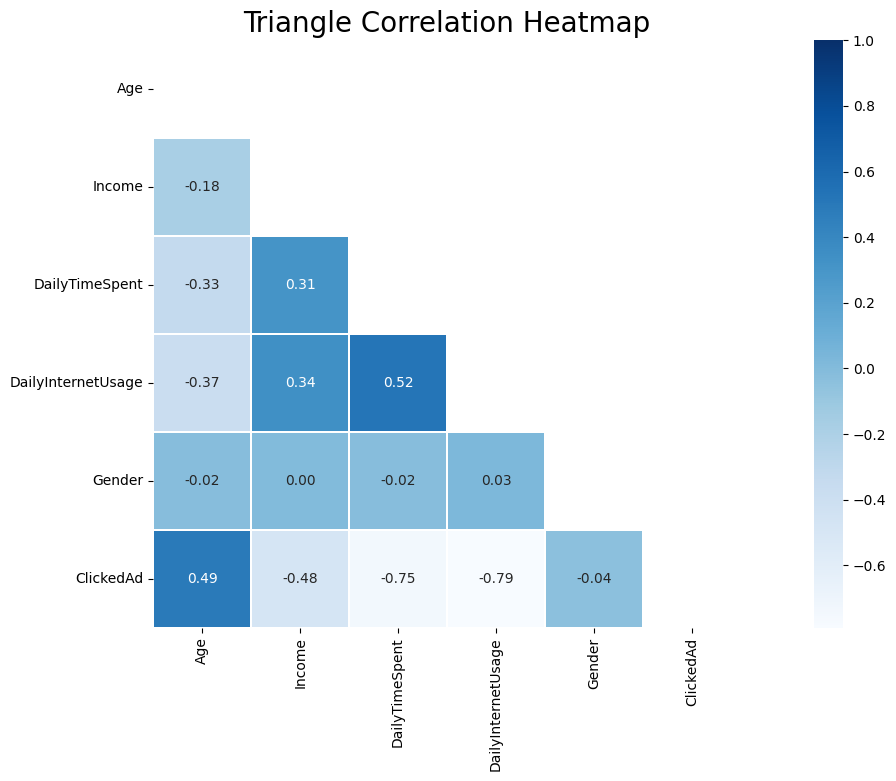

In [46]:
# Correlation plot
plt.figure(figsize=(16, 9))
corrmat = df[features].corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool))
sns.heatmap(corrmat, mask=mask, cmap='Blues', annot=True, fmt='.2f', vmin=corrmat.values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={'fontsize':10})
plt.title('Triangle Correlation Heatmap', fontsize=20)
plt.tight_layout(pad=5)
plt.show()

🔎 Insights
- Fitur target atau `ClickedAd` berkorelasi kuat terhadap `DailyTimeSpent` dan `DailyInternetUsage`.
- Fitur `Gender`, `Income`, `DailyTimeSpent`, dan `DailyInternetUsage` berkorelasi negatif terhadap `Age`.
- Makin besar `Income` pengguna, makin tinggi `DailyTimeSpent` dan `DailyInternetUsage`.
- Tidak ada _multicollinearity_. 

## Data Cleaning

### Detect Missing Values

In [47]:
# Check the features that have missing values
print(df.isna().values.any())

# Summarize missing value
total = df.isna().sum().sort_values(ascending=False)
percent = round(df.isna().mean() * 100, 2).sort_values(ascending=False)

na = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage (%)'])
na = na[na['Total'] > 0]
na.reset_index(inplace=True)
na.rename(columns={'index': 'Feature Name'}, inplace=True)
na

True


,Feature Name,Total,Percentage (%)
0,DailyTimeSpent,13,1.3
1,Income,13,1.3
2,DailyInternetUsage,11,1.1
3,Gender,3,0.3


🔎 Observasi
- Terdapat _missing values_ pada beberapa fitur, seperti `Income`, `DailyTimeSpent`, dan `DailyInternetUsage`, yang jumlahnya kurang dari 2% dan kita akan mengganti nilai-nilai tersebut dengan median, karena lebih _robust_.
- Namun, _missing values_ pada fitur kategorikal, yaitu `Gender` akan diisi dengan modus.

In [48]:
# Fill missing values with median
df['Income'].fillna(df['Income'].median(), inplace=True)
df['DailyTimeSpent'].fillna(df['DailyTimeSpent'].median(), inplace=True)
df['DailyInternetUsage'].fillna(df['DailyInternetUsage'].median(), inplace=True)

# Fill missing values with mode
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Gender'] = df['Gender'].astype('int64')

# Recheck
df.isna().sum().sum()

0

✅ Dataset sudah bersih dari _missing values_.

### Detect Duplicate Values

In [49]:
# Check the features that have duplicate values
print(df.duplicated().any())
df.duplicated().sum()

False


0

✅ Dataset bebas dari _duplicate values_.

### Number of Unique Classes

In [50]:
# Count number of unique class
df.nunique().sort_values(ascending=False)

Income                987
DailyInternetUsage    955
DailyTimeSpent        890
Age                    43
Day                    31
City                   30
Hour                   24
Province               16
AdCategory             10
Month                   7
Week                    7
AgeGroup                5
Gender                  2
ClickedAd               2
dtype: int64

In [51]:
values = {'Feature Name': [], 'Unique Classes': []}
for col in df.columns:
    values['Feature Name'].append(col)
    values['Unique Classes'].append(df[col].unique())
    
unique = pd.DataFrame(values)
unique

,Feature Name,Unique Classes
0,DailyTimeSpent,"[68.95, 80.23, 69.47, 74.15, 68.37, 59.99, 88...."
1,Age,"[35, 31, 26, 29, 23, 33, 48, 30, 20, 49, 37, 2..."
2,Income,"[432837300.0, 479092950.00000006, 418501580.0,..."
3,DailyInternetUsage,"[256.09, 193.77, 236.5, 245.89, 225.58, 226.74..."
4,Gender,"[0, 1]"
5,ClickedAd,"[0, 1]"
6,City,"[Jakarta Timur, Denpasar, Surabaya, Batam, Med..."
7,Province,"[Daerah Khusus Ibukota Jakarta, Bali, Jawa Tim..."
8,AdCategory,"[Furniture, Food, Electronic, House, Finance, ..."
9,AgeGroup,"['31-40', '21-30', '41-50', '< 21', '> 50'] Ca..."


🔽 `City`

In [52]:
df['City'].unique()

array(['Jakarta Timur', 'Denpasar', 'Surabaya', 'Batam', 'Medan',
       'Jakarta Barat', 'Bandung', 'Bandar Lampung', 'Jakarta Pusat',
       'Depok', 'Serang', 'Padang', 'Semarang', 'Makassar', 'Malang',
       'Jakarta Utara', 'Pontianak', 'Jakarta Selatan', 'Tasikmalaya',
       'Surakarta', 'Bekasi', 'Tangerang', 'Cimahi', 'Banjarmasin',
       'Palembang', 'Samarinda', 'Pakanbaru', 'Tangerang Selatan',
       'Bogor', 'Balikpapan'], dtype=object)

🔽 `Province`

In [53]:
df['Province'].unique()

array(['Daerah Khusus Ibukota Jakarta', 'Bali', 'Jawa Timur',
       'Kepulauan Riau', 'Sumatra Utara', 'Jawa Barat', 'Lampung',
       'Banten', 'Sumatra Barat', 'Jawa Tengah', 'Sulawesi Selatan',
       'Kalimantan Barat', 'Kalimantan Selatan', 'Sumatra Selatan',
       'Kalimantan Timur', 'Riau'], dtype=object)

🔽 `AdCategory`

In [54]:
df['AdCategory'].unique()

array(['Furniture', 'Food', 'Electronic', 'House', 'Finance', 'Travel',
       'Health', 'Bank', 'Fashion', 'Otomotif'], dtype=object)

🔎 Observasi
- Pada fitur `City` dan `Province` memiliki terlalu banyak kategori, sehingga kita akan membuat fitur baru, yaitu `Region`.
- Pada fitur `AdCategory` perlu dilakukan _regrouping_ atau _renaming_, seperti:
    - `House` dan `Furniture` → `Rumah Tangga`,
    - `Travel`, `Fashion`, `Food`, dan `Health` → `Gaya Hidup`,
    - `Finance` dan `Bank` → `Jasa Keuangan`,
    - `Electronic` → `Elektronik`.

In [55]:
df['Region'] = np.where( ((df['Province']) == 'Daerah Khusus Ibukota Jakarta') 
                       | ((df['Province']) == 'Banten')
                       | ((df['Province']) == 'Jawa Barat') 
                       | ((df['Province']) == 'Jawa Tengah')
                       | ((df['Province']) == 'Jawa Timur'), 'Jawa',
                       np.where( ((df['Province']) == 'Riau')
                               | ((df['Province']) == 'Kepulauan Riau') 
                               | ((df['Province']) == 'Sumatra Utara') 
                               | ((df['Province']) == 'Sumatra Barat') 
                               | ((df['Province']) == 'Sumatra Selatan')
                               | ((df['Province']) == 'Lampung'), 'Sumatra',
                               np.where( ((df['Province']) == 'Kalimantan Barat')
                                       | ((df['Province']) == 'Kalimantan Selatan')
                                       | ((df['Province']) == 'Kalimantan Timur'), 'Kalimantan',
                                       np.where( ((df['Province']) == 'Bali'), 'Bali', 'Sulawesi'))))
df['Region'].value_counts()

Region
Jawa          682
Sumatra       195
Kalimantan     69
Sulawesi       33
Bali           21
Name: count, dtype: int64

In [56]:
# Fix incorrect values
df['AdCategory'] = df['AdCategory'].replace({
    'House'      : 'Rumah Tangga',
    'Furniture'  : 'Rumah Tangga',
    'Travel'     : 'Gaya Hidup',
    'Fashion'    : 'Gaya Hidup',
    'Food'       : 'Gaya Hidup',
    'Health'     : 'Gaya Hidup',
    'Finance'    : 'Jasa Keuangan',
    'Bank'       : 'Jasa Keuangan',
    'Electronic' : 'Elektronik'
})
df['AdCategory'].value_counts()

AdCategory
Gaya Hidup       403
Rumah Tangga     207
Jasa Keuangan    181
Otomotif         112
Elektronik        97
Name: count, dtype: int64

In [57]:
df.drop(columns=['City', 'Province'], inplace=True)

## Feature Engineering

### Feature Encoding

In [58]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['AdCategory', 'AgeGroup', 'Region'], dtype='object')

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['AdCategory'] = encoder.fit_transform(df['AdCategory'])
df['AgeGroup'] = encoder.fit_transform(df['AgeGroup'])
df['Region'] = encoder.fit_transform(df['Region'])

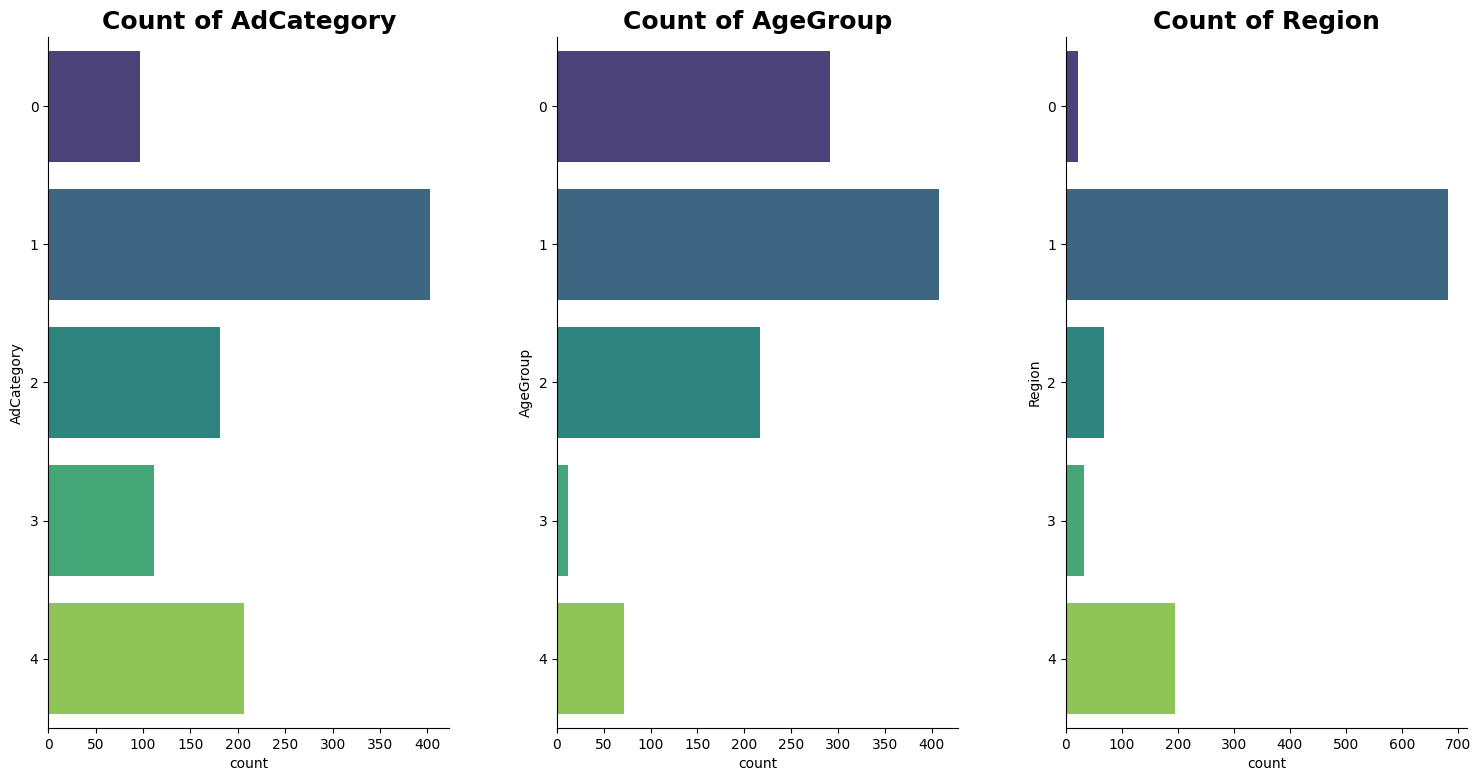

In [60]:
plt.figure(figsize=(16, 9))
for i in range(0, len(cat_cols)):
    plt.subplot(1, 3, i+1)
    ax = sns.countplot(y=df[cat_cols[i]], palette='viridis')
    plt.title(f'Count of {cat_cols[i]}', fontsize=18, weight='bold')
    sns.despine()
    plt.tight_layout(pad=5)

plt.show()

# Data Modeling

In [61]:
cols = ['Age', 'AgeGroup', 'Gender', 'Region',
        'Income', 'DailyTimeSpent', 'DailyInternetUsage', 'AdCategory',
        'Month', 'Week', 'Day', 'Hour',
        'ClickedAd']
df_model = df[cols].copy()

In [62]:
# Define X (features) and y (target)
X = df_model.drop(columns='ClickedAd').copy()  
y = df_model['ClickedAd'].copy()

## Train Test Splitting

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

print('Split 80:20')
print('Total baris dan kolom dari X train set:', X_train.shape)
print('Total baris dan kolom dari X test set :', X_test.shape)

Split 80:20
Total baris dan kolom dari X train set: (800, 12)
Total baris dan kolom dari X test set : (200, 12)


In [64]:
y_train.value_counts()

ClickedAd
0    400
1    400
Name: count, dtype: int64

## Feature Scaling: Normalization

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Determine Models with `LazyPredict` Library

Referensi: https://github.com/shankarpandala/lazypredict/

In [66]:
# pip install lazypredict

### Without Normalization

In [67]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(f'Top 4 Models without Normalization\n{models.head(4)}')

100%|██████████| 29/29 [00:04<00:00,  6.89it/s]

Top 4 Models without Normalization
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
LinearSVC                          0.98               0.98     0.98      0.98  \
LogisticRegression                 0.98               0.98     0.98      0.98   
CalibratedClassifierCV             0.98               0.98     0.98      0.98   
QuadraticDiscriminantAnalysis      0.97               0.97     0.97      0.97   

                               Time Taken  
Model                                      
LinearSVC                            0.05  
LogisticRegression                   0.14  
CalibratedClassifierCV               0.14  
QuadraticDiscriminantAnalysis        0.05  


🔎 Observasi
- Model algoritma tanpa normalisasi yang memiliki nilai akurasi tertinggi adalah `LinearSVC`, `LogisticRegression`, dan `CalibratedClassifierCV`, yaitu sebesar 0,98. 
- Model algoritma yang lain memiliki nilai akurasi sebesar 0,97.

### With Normalization

In [68]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

print(f'Top 4 Models with Normalization\n{models.head(4)}')

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:03<00:00,  9.20it/s]

Top 4 Models with Normalization
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score   
Model                                                                           
LinearSVC                          0.98               0.98     0.98      0.98  \
QuadraticDiscriminantAnalysis      0.98               0.98     0.98      0.98   
LogisticRegression                 0.97               0.97     0.97      0.97   
CalibratedClassifierCV             0.97               0.97     0.97      0.97   

                               Time Taken  
Model                                      
LinearSVC                            0.05  
QuadraticDiscriminantAnalysis        0.03  
LogisticRegression                   0.04  
CalibratedClassifierCV               0.14  


🔎 Observasi
- Model algoritma dengan normalisasi yang memiliki nilai akurasi tertinggi adalah `LinearSVC` dan `QuadraticDiscriminantAnalysis`, yaitu sebesar 0,98. 
- Algoritma yang lain memiliki nilai akurasi sebesar 0,97.
- Pada algoritma `QuadraticDiscriminantAnalysis` mengalami peningkatan nilai akurasi secara signifikan dengan normalisasi, tetapi sebaliknya, `LogisticRegression` dan `CalibratedClassifierCV` mengalami penurunan.

## Define Functions

In [69]:
# Define create_model() function
def create_model(X_train, X_test, y_train, y_test, models):
    performance = []
    for i in models:
        model = i
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        train_accuracy, test_accuracy = accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)
        train_precision, test_precision = precision_score(y_train, y_pred_train, pos_label = 0), precision_score(y_test, y_pred, pos_label = 0)
        train_recall, test_recall = recall_score(y_train, y_pred_train, pos_label = 0), recall_score(y_test, y_pred, pos_label = 0)
        train_f1, test_f1 = f1_score(y_train, y_pred_train, pos_label = 0), f1_score(y_test, y_pred, pos_label = 0)
        train_f2, test_f2 = fbeta_score(y_train, y_pred_train, pos_label = 0, beta = 2), fbeta_score(y_test, y_pred, pos_label = 0, beta = 2)
        performance.append([train_accuracy, test_accuracy,
                            train_precision, test_precision,
                            train_recall, test_recall,
                            train_f1, test_f1,
                            train_f2, test_f2])
    
    performance_df = pd.DataFrame(data = performance, 
                                  columns = 'Train\nAccuracy, Test\nAccuracy, Train\nPrecision, Test\nPrecision, Train\nRecall, Test\nRecall, Train\nF1 Score, Test\nF1 Score, Train\nF2 Score, Test\nF2 Score'.split(','),
                                  index = [str(model).split('(')[0] for model in models])
    
    plt.figure(figsize = (12, 10))
    sns.heatmap(performance_df, cmap = 'mako', annot = True, annot_kws = {'fontsize' : 12})
    plt.tick_params(axis = 'both',
                    which = 'major',
                    labelsize = 12,
                    labelbottom = False, bottom = False,
                    labeltop = True, top = False)
    plt.tight_layout()
    plt.show()

# Define c_matrix_plot() function
def c_matrix_plot(y_test, y_pred):

    c_matrix = confusion_matrix(y_test, y_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    ax = sns.heatmap(c_matrix, annot = labels, fmt = '', cmap = 'mako')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['Not Clicked Ad', 'Clicked Ad'])
    ax.yaxis.set_ticklabels(['Not Clicked Ad', 'Clicked Ad'])
    plt.show()

# Define model_evaluation() function
def model_evaluation(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print('Accuracy (Train): %.2f' % accuracy_score(y_train, y_pred_train))
    print('Accuracy (Test): %.2f' % accuracy_score(y_test, y_pred))

    print('Precision (Train): %.2f' % precision_score(y_train, y_pred_train))
    print('Precision (Test): %.2f' % precision_score(y_test, y_pred))

    print('Recall (Train): %.2f' % recall_score(y_train, y_pred_train))
    print('Recall (Test): %.2f' % recall_score(y_test, y_pred))

    print('F1-Score (Train): %.2f' % f1_score(y_train, y_pred_train))
    print('F1-Score (Test): %.2f' % f1_score(y_test, y_pred))

    print('F2-Score (Train): %.2f' % fbeta_score(y_train, y_pred_train, beta = 2))
    print('F2-Score (Test): %.2f' % fbeta_score(y_test, y_pred, beta = 2))
    
    print('ROC-AUC Score (Train-Probability): %.2f' % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    print('ROC-AUC Score (Test-Probability): %.2f' % roc_auc_score(y_test, y_pred_proba[:, 1]))

# Define train_test_result() function
def train_test_result(y_train, y_pred_train, y_test, y_pred):
    # Evaluate model on training set
    print('TRAINING RESULTS:')
    print('-------------------------------------------------------')    
    print('Classification Report:')
    print(classification_report(y_train, y_pred_train))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_pred_train))
    print('-------------------------------------------------------')

    # Evaluate model on test set
    print('\nTESTING RESULTS:')
    print('-------------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('-------------------------------------------------------')

# Define show_best_parameter() function
def show_best_parameter(model):
    print(model.best_estimator_.get_params())

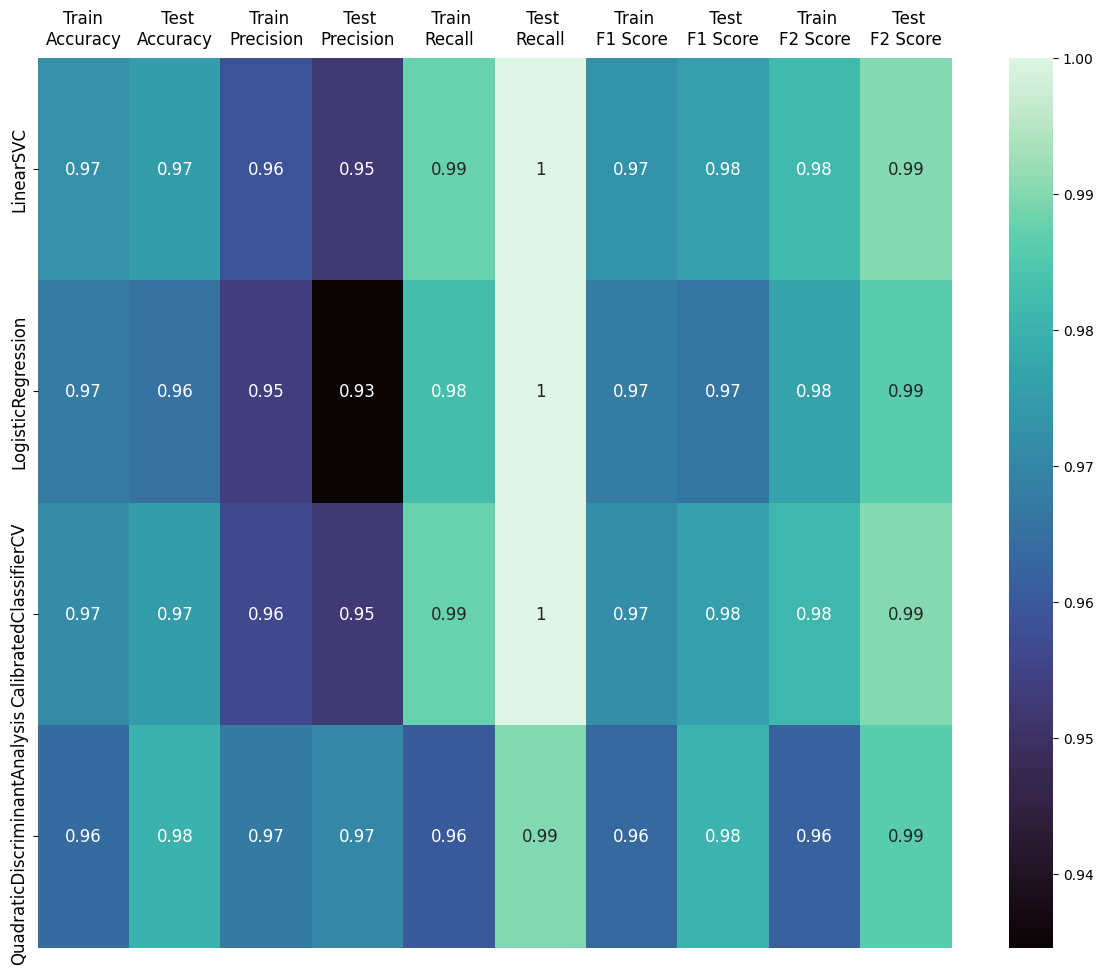

In [70]:
# Define Classification Algorithm
models = [
    LinearSVC(),
    LogisticRegression(),
    CalibratedClassifierCV(),
    QuadraticDiscriminantAnalysis()
]

# Create model
create_model(X_train_scaled, X_test_scaled, y_train, y_test, models)

🔎 Insights
- Pada tahap ini, kami menggunakan metrik evaluasi yang digunakan sebagai pertimbangan untuk memilih model: _accuracy_, yaitu metrik yang mengukur sejauh mana model dapat memprediksi dengan benar. Makin tinggi akurasi, makin baik performa model.
- Berdasarkan hasil evaluasi model, 3 model teratas dengan hasil yang relatif sama adalah `LinearSVC`, `QuadraticDiscriminantAnalysis`, dan `LogisticRegression`.
- Oleh karena kompleksitas model menjadi faktor yang harus dipertimbangkan, maka kami memutuskan untuk melakukan _hyperparameter tuning_ terhadap `LogisticRegression`, karena merupakan model linier yang lebih sederhana dibandingkan `LinearSVC`.

### Logistic Regression

#### Fit Model

In [71]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=100)
lr.fit(X_train, y_train)
model_evaluation(lr)

Accuracy (Train): 0.50
Accuracy (Test): 0.50
Precision (Train): 0.00
Precision (Test): 0.00
Recall (Train): 0.00
Recall (Test): 0.00
F1-Score (Train): 0.00
F1-Score (Test): 0.00
F2-Score (Train): 0.00
F2-Score (Test): 0.00
ROC-AUC Score (Train-Probability): 0.77
ROC-AUC Score (Test-Probability): 0.74


In [72]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=100)
lr.fit(X_train_scaled, y_train)
model_evaluation(lr)

Accuracy (Train): 0.50
Accuracy (Test): 0.50
Precision (Train): 0.00
Precision (Test): 0.00
Recall (Train): 0.00
Recall (Test): 0.00
F1-Score (Train): 0.00
F1-Score (Test): 0.00
F2-Score (Train): 0.00
F2-Score (Test): 0.00
ROC-AUC Score (Train-Probability): 0.50
ROC-AUC Score (Test-Probability): 0.50


#### Hyperparameter Tuning

Referensi: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# Hyperparameter Tuning
penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
solver = ['liblinear', 'saga']
max_iter = [100, 200, 300, 400, 500]
hyperparameters = {
    'penalty': penalty,
    'C': C,
    'solver': solver,
    'max_iter': max_iter
}

rs_lr = LogisticRegression(random_state=100)
rs_lr = RandomizedSearchCV(rs_lr, hyperparameters, scoring='accuracy', random_state=100, cv=StratifiedKFold(n_splits=5), n_iter=50)
rs_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(random_state=100), n_iter=50,
                   param_distributions={'C': [0.0001, 0.0006040404040404041,
                                              0.0011080808080808082,
                                              0.0016121212121212123,
                                              0.002116161616161616,
                                              0.0026202020202020205,
                                              0.0031242424242424243,
                                              0.003628282828282828,
                                              0.004132323232323233,
                                              0.004...
                                              0.009676767676767678,
                                              0.010180808080808082,
                                              0.010684848484848485,
                                              0.011188888888888889,
                                              0.011692929292929293,
                                              0.012196969696969697,
                                              0.012701010101010102,
                                              0.013205050505050506,
                                              0.01370909090909091,
                                              0.014213131313131313,
                                              0.014717171717171717, ...],
                                        'max_iter': [100, 200, 300, 400, 500],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=100, scoring='accuracy')

In [74]:
# Predict & Evaluation
model_evaluation(rs_lr)

Accuracy (Train): 0.91
Accuracy (Test): 0.93
Precision (Train): 0.94
Precision (Test): 0.95
Recall (Train): 0.88
Recall (Test): 0.90
F1-Score (Train): 0.91
F1-Score (Test): 0.92
F2-Score (Train): 0.89
F2-Score (Test): 0.91
ROC-AUC Score (Train-Probability): 0.96
ROC-AUC Score (Test-Probability): 0.97


In [75]:
# Best parameter
show_best_parameter(rs_lr)

{'C': 0.030342424242424244, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 300, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 100, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [76]:
# Prediction on training set
y_pred_train = rs_lr.predict(X_train)
# Prediction on testing set
y_pred = rs_lr.predict(X_test)

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       400
           1       0.94      0.88      0.91       400

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

-------------------------------------------------------
Confusion Matrix:
[[377  23]
 [ 50 350]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       100
           1       0.95      0.90      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200


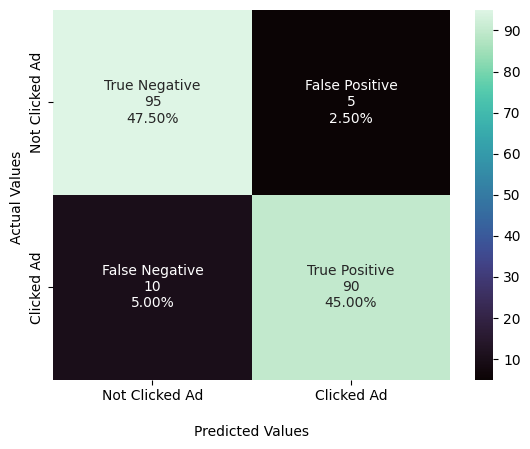

In [77]:
y_pred = rs_lr.predict(X_test)
c_matrix_plot(y_test, y_pred)

🔎 Insights
- Terdapat 90 prediksi benar yang diklasifikasikan sebagai klik iklan (True Positive, TP).
- Terdapat 5 prediksi salah yang diklasifikasikan sebagai klik iklan padahal tidak (False Positive, FP).
- Terdapat 10 prediksi salah yang diklasifikasikan sebagai tidak klik iklan padahal iya (False Negative, FN).
- Terdapat 95 prediksi benar yang diklasifikasikan sebagai tidak klik iklan (True Negative, TN).

In [78]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(16, 9))
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid()
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='tab:blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='tab:orange')
    plt.plot(train_sizes, train_mean, 'o-', color='tab:blue', label='Training Accuracy')
    plt.plot(train_sizes, test_mean, 'o-', color='tab:orange', label='Validation Accuracy')
    
    plt.legend(loc='best')
    plt.show()

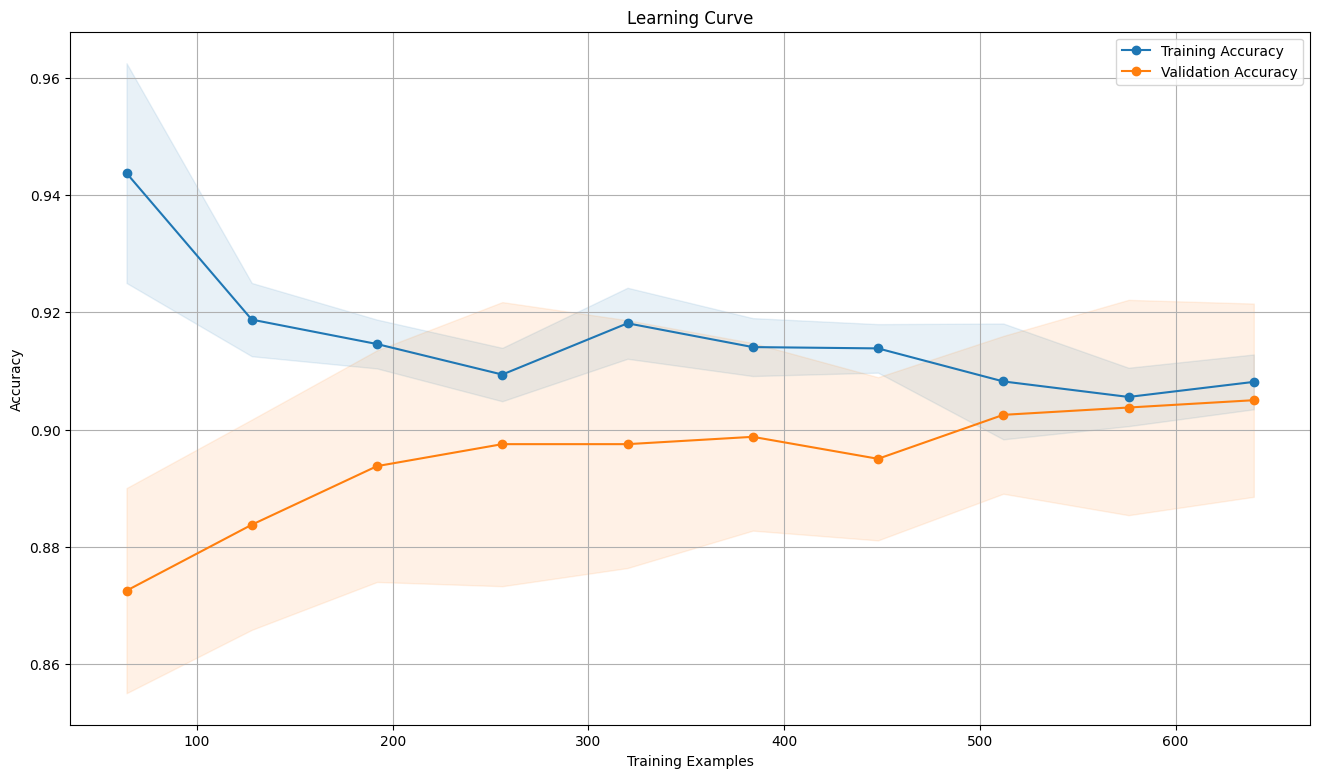

In [79]:
plot_learning_curve(rs_lr, X_train, y_train)

#### Feature Importance

In [80]:
# Define show_feature_importance() function
def show_feature_importance(model, feature_names, n_features=25):
    coef = model.coef_[0]
    feat_importances = pd.Series(coef, index=feature_names)
    ax = feat_importances.nlargest(n_features).plot(kind='barh', figsize=(16, 9))
    ax.invert_yaxis()

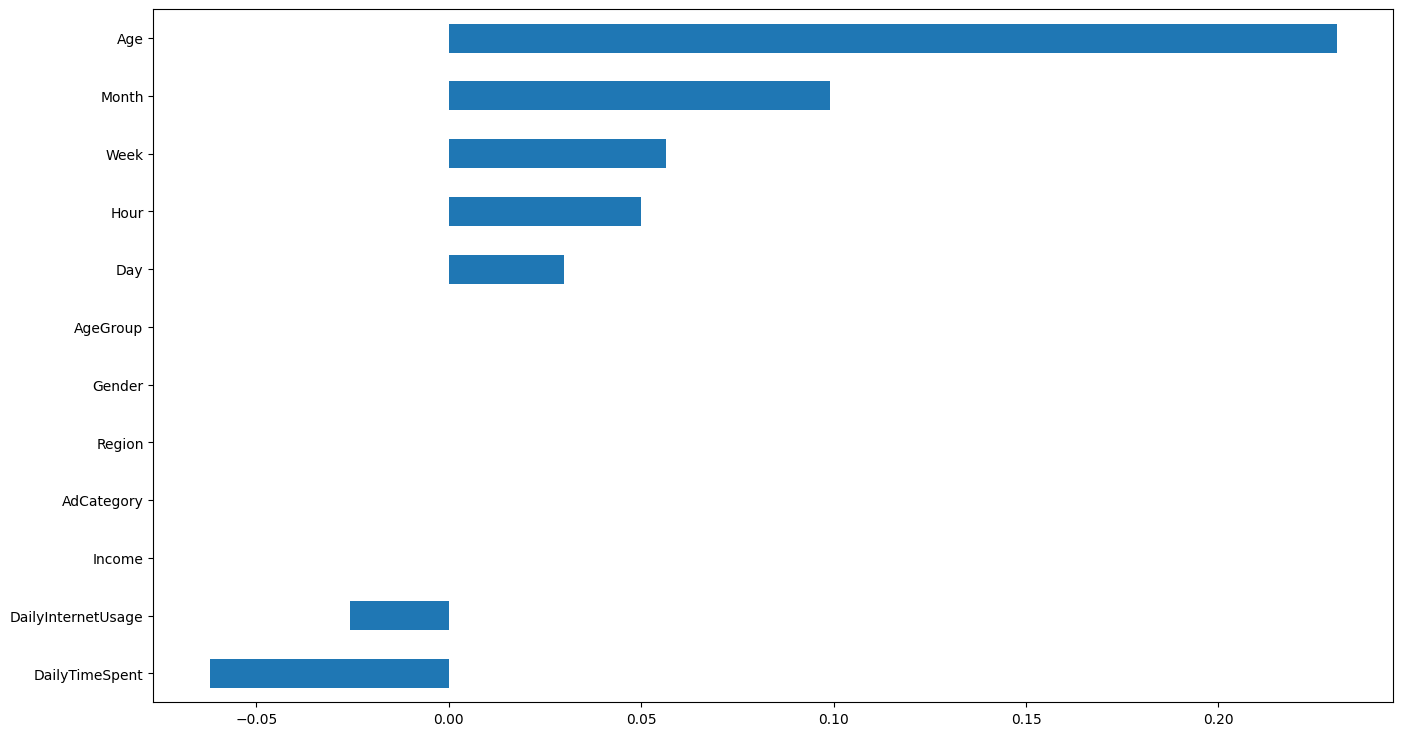

In [81]:
show_feature_importance(rs_lr.best_estimator_, X.columns)

🔎 Insights
- Fitur `Age` berkorelasi positif yang lebih kuat dibandingkan dengan fitur `Month`. Artinya, makin tua usia pengguna, makin besar kecenderungan untuk mengeklik iklan.
- Sementara itu, fitur `DailyTimeSpent` dan `DailyInternetUsage` berkorelasi negatif terhadap klik iklan. Artinya, pengguna yang termasuk dalam kategori nonaktif akan cenderung klik iklan.

## Save the Model

In [82]:
# import joblib

# joblib.dump(rs_lr, 'clicked_ads_classifier_logreg.joblib')

In [83]:
# production_model = joblib.load('clicked_ads_classifier_logreg.joblib')